<a href='#Obtain'>Obtain</a>

<a href='#Scrub'>Scrub</a>

<a href='#Explore'>Explore and Preprocessing</a>

<a href='#Model'>Model</a>    

<a href='#Results'>Results</a>

<a href='#Deployment'>Deployment</a>

<a href='#Future'>Future Work</a>

<a href='#References'>References</a>

# Background <a id='Background'></a>

As a teacher in high school, I was often tasked with finding reading material that was appropriate for my student's specific lexile level, or reading level. Vocabulary, sentence structure, length of phrases are all considered when determining what lexile level a text is at. Most of the time texts that have labeled lexile levels are made specifically for education. However, as teachers, we are encouraged to bring relevant news and breaking research into the classroom. This type of content does not often have a labeled lexile level. In order to differeientate to meet every student's needs, something like lexile level needs to be considered. Currently, most teachers will pre-read a text during planning and make their best guess as to what lexile level the prepared texts likely are. With this model, I aim to create a tool that will take out the guess work in predicting lexile levels, that is easy to use, and that returns results almost instantly.

# Obtain <a id='Obtain'></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle
from math import floor
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
import re
from sklearn.manifold import TSNE
import nltk
from nltk.tokenize import TextTilingTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import random
from keras import models, layers, optimizers
from keras.models import load_model

Using TensorFlow backend.


## Full Texts

### Acquire Available Titles, Authors, and URLs

In [2]:
def get_titles_and_urls(website_list):
    '''To acquire a list of titles and website extenstions for gutenberg.org from the Bookshelves part of the website. 
    Requires a list of website urls to be passed in. 
    Returns titles and link extensions'''
    titles = []
    links = []
    for counter, website in enumerate(website_list):
        driver = webdriver.Firefox()
        driver.implicitly_wait(5)
        driver.get(website)
        for x, y  in enumerate(driver.find_elements_by_xpath('./html/body/div[1]/div[2]/div[2]/div/ul/li')):
            try:
                if [i.get_attribute('alt') for i in y.find_elements_by_xpath('./a[@class="image"]/img')][0] == 'BookIcon.png':
                    titles.append(y.find_elements_by_xpath('./a')[0].text)
                    links.append(y.find_elements_by_xpath('./a')[0].get_attribute('href'))
                else:
                    continue
            except:
                continue
        driver.quit()
        print('Website', counter+1, 'information acquired!')
    print('Is length of titles scrapped and links scrapped equal?', len(titles)==len(links))
    return titles, links

In [3]:
websites = ["https://www.gutenberg.org/wiki/Children%27s_Literature_(Bookshelf)", 
            "https://www.gutenberg.org/wiki/Children%27s_Fiction_(Bookshelf)",
            "https://www.gutenberg.org/wiki/Adventure_(Bookshelf)",
            "https://www.gutenberg.org/wiki/Fantasy_(Bookshelf)",
            "https://www.gutenberg.org/wiki/Humor_(Bookshelf)",
            "https://www.gutenberg.org/wiki/Mystery_Fiction_(Bookshelf)",
            "https://www.gutenberg.org/wiki/Movie_Books_(Bookshelf)",
            "https://www.gutenberg.org/wiki/Science_Fiction_(Bookshelf)",
            "https://www.gutenberg.org/wiki/Children%27s_History_(Bookshelf)",
            "https://www.gutenberg.org/wiki/Plays_(Bookshelf)"]
titles, links = get_titles_and_urls(websites)

Website 1 information acquired!
Website 2 information acquired!
Website 3 information acquired!
Website 4 information acquired!
Website 5 information acquired!
Website 6 information acquired!
Website 7 information acquired!
Website 8 information acquired!
Website 9 information acquired!
Website 10 information acquired!
Is length of titles scrapped and links scrapped equal? True


### Prep URLs for Webscrapping

In [4]:
links_to_search = []
for x in links:
    links_to_search.append(x.split('/')[4])
len(links_to_search)

2437

### Webscrapping for Full Texts

In [5]:
special_cases = [57, 158, 189, 189, 590, 941, 2175]
for x in special_cases:
    titles.pop(x)
    links_to_search.pop(x)

In [6]:
texts = []
urls_used = []
urls_not_used = []
for i in range(0, len(links_to_search)):
    to_find = links_to_search[i]
    print(i, to_find)
    try:
        driver = webdriver.Firefox()
        driver.implicitly_wait(5)
        driver.get("https://www.gutenberg.org/ebooks/"+to_find+".txt.utf-8")
        text = driver.find_element_by_xpath('//pre')
        texts.append(text.text)
        driver.quit()
        urls_used.append(i)
        print('Text acquired!')
    except NoSuchElementException as inst:
        print(inst)          # __str__ allows args to be printed directly,
        driver = webdriver.Firefox()
        driver.implicitly_wait(5)
        driver.get("https://www.gutenberg.org/files/"+to_find+"/"+to_find+"-0.txt")
        text = driver.find_element_by_xpath('//pre')
        texts.append(text.text)
        driver.quit()
        urls_used.append(i)
        print('Text acquired!')
    driver.quit()

0 22234
Text acquired!
1 2726
Text acquired!
2 163
Text acquired!
3 5830
Text acquired!
4 2786
Text acquired!
5 3499
Text acquired!
6 10360
Text acquired!
7 2788
Text acquired!
8 514
Text acquired!
9 7425
Text acquired!
10 5352
Text acquired!
11 3806
Text acquired!
12 8188
Text acquired!
13 2787
Text acquired!
14 17337
Text acquired!
15 21946
Text acquired!
16 2804
Text acquired!
17 22022
Text acquired!
18 3795
Text acquired!
19 16
Text acquired!
20 4357
Text acquired!
21 22566
Text acquired!
22 517
Text acquired!
23 518
Text acquired!
24 961
Text acquired!
25 519
Text acquired!
26 520
Text acquired!
27 25519
Text acquired!
28 24459
Text acquired!
29 419
Text acquired!
30 54
Text acquired!
31 5660
Text acquired!
32 22225
Text acquired!
33 436
Text acquired!
34 5312
Text acquired!
35 486
Text acquired!
36 955
Text acquired!
37 25581
Text acquired!
38 485
Text acquired!
39 957
Text acquired!
40 4358
Text acquired!
41 4356
Text acquired!
42 16259
Text acquired!
43 956
Text acquired!
44 96

330 21719
Text acquired!
331 23372
Text acquired!
332 21823
Text acquired!
333 23267
Text acquired!
334 21720
Text acquired!
335 23262
Text acquired!
336 21721
Text acquired!
337 21725
Text acquired!
338 21710
Text acquired!
339 21726
Text acquired!
340 21727
Text acquired!
341 10929
Text acquired!
342 21729
Text acquired!
343 23373
Text acquired!
344 21730
Text acquired!
345 23492
Text acquired!
346 23380
Text acquired!
347 21202
Text acquired!
348 21735
Text acquired!
349 21732
Text acquired!
350 23505
Text acquired!
351 23263
Text acquired!
352 21737
Text acquired!
353 23384
Text acquired!
354 21733
Text acquired!
355 15689
Text acquired!
356 21734
Text acquired!
357 21736
Text acquired!
358 23389
Text acquired!
359 21757
Text acquired!
360 21758
Text acquired!
361 21738
Text acquired!
362 21739
Text acquired!
363 21705
Text acquired!
364 21740
Text acquired!
365 21741
Text acquired!
366 21742
Text acquired!
367 21743
Text acquired!
368 21744
Text acquired!
369 21695
Text acquired!


654 288
Text acquired!
655 11752
Text acquired!
656 9608
Text acquired!
657 9663
Text acquired!
658 10882
Text acquired!
659 11639
Text acquired!
660 8715
Text acquired!
661 9829
Text acquired!
662 8771
Text acquired!
663 9488
Text acquired!
664 10041
Text acquired!
665 17134
Text acquired!
666 2414
Text acquired!
667 831
Text acquired!
668 15551
Text acquired!
669 16435
Text acquired!
670 7477
Text acquired!
671 4282
Text acquired!
672 8129
Text acquired!
673 7838
Text acquired!
674 8395
Text acquired!
675 1311
Text acquired!
676 11283
Text acquired!
677 19393
Message: Unable to locate element: //pre

Text acquired!
678 13664
Text acquired!
679 10806
Text acquired!
680 11440
Text acquired!
681 5713
Text acquired!
682 13821
Text acquired!
683 8183
Text acquired!
684 13820
Text acquired!
685 19959
Text acquired!
686 19973
Text acquired!
687 19976
Text acquired!
688 11097
Text acquired!
689 10662
Text acquired!
690 10002
Text acquired!
691 12753
Text acquired!
692 6582
Text acquired!
693

983 41064
Text acquired!
984 32436
Text acquired!
985 30971
Text acquired!
986 51650
Text acquired!
987 51184
Text acquired!
988 22239
Text acquired!
989 31501
Text acquired!
990 37653
Text acquired!
991 29542
Text acquired!
992 51273
Text acquired!
993 27392
Text acquired!
994 29303
Text acquired!
995 51397
Text acquired!
996 51132
Text acquired!
997 604
Text acquired!
998 29618
Text acquired!
999 23688
Text acquired!
1000 31840
Text acquired!
1001 30427
Text acquired!
1002 31547
Text acquired!
1003 1607
Text acquired!
1004 51274
Text acquired!
1005 24517
Text acquired!
1006 51129
Text acquired!
1007 23148
Text acquired!
1008 51546
Text acquired!
1009 29623
Text acquired!
1010 8681
Text acquired!
1011 51823
Text acquired!
1012 51330
Text acquired!
1013 29310
Text acquired!
1014 29298
Text acquired!
1015 30307
Text acquired!
1016 30303
Text acquired!
1017 32029
Text acquired!
1018 29475
Text acquired!
1019 23868
Text acquired!
1020 22701
Text acquired!
1021 7052
Text acquired!
1022 730

Text acquired!
1290 50826
Text acquired!
1291 51396
Text acquired!
1292 50863
Text acquired!
1293 19660
Text acquired!
1294 22754
Text acquired!
1295 50682
Text acquired!
1296 51498
Text acquired!
1297 21582
Text acquired!
1298 32162
Text acquired!
1299 32705
Text acquired!
1300 20856
Text acquired!
1301 52167
Message: Unable to locate element: //pre

Text acquired!
1302 52326
Message: Unable to locate element: //pre

Text acquired!
1303 50571
Text acquired!
1304 31262
Text acquired!
1305 29559
Text acquired!
1306 31962
Text acquired!
1307 51588
Text acquired!
1308 30267
Text acquired!
1309 29140
Text acquired!
1310 28933
Text acquired!
1311 23535
Text acquired!
1312 51256
Text acquired!
1313 51570
Text acquired!
1314 51475
Text acquired!
1315 31897
Text acquired!
1316 24543
Text acquired!
1317 29046
Text acquired!
1318 23831
Text acquired!
1319 4920
Text acquired!
1320 5965
Text acquired!
1321 5699
Text acquired!
1322 5703
Text acquired!
1323 32067
Text acquired!
1324 30251
Text acqui

Text acquired!
1596 23028
Text acquired!
1597 26782
Text acquired!
1598 51781
Text acquired!
1599 51712
Text acquired!
1600 21782
Text acquired!
1601 23379
Text acquired!
1602 51727
Text acquired!
1603 17394
Text acquired!
1604 13841
Text acquired!
1605 29975
Text acquired!
1606 51609
Text acquired!
1607 27665
Text acquired!
1608 22470
Text acquired!
1609 51152
Text acquired!
1610 50819
Text acquired!
1611 51549
Text acquired!
1612 22579
Text acquired!
1613 51436
Text acquired!
1614 51082
Text acquired!
1615 23164
Text acquired!
1616 51353
Text acquired!
1617 51493
Text acquired!
1618 51530
Text acquired!
1619 50753
Text acquired!
1620 29662
Text acquired!
1621 51101
Text acquired!
1622 25024
Text acquired!
1623 23162
Text acquired!
1624 51461
Text acquired!
1625 51380
Text acquired!
1626 29504
Text acquired!
1627 50905
Text acquired!
1628 24104
Text acquired!
1629 23439
Text acquired!
1630 24149
Text acquired!
1631 42901
Text acquired!
1632 51782
Text acquired!
1633 30408
Text acquire

Text acquired!
1905 30334
Message: Unable to locate element: //pre

Text acquired!
1906 23942
Text acquired!
1907 29027
Text acquired!
1908 24150
Text acquired!
1909 29789
Text acquired!
1910 30242
Text acquired!
1911 29789
Text acquired!
1912 43038
Text acquired!
1913 35103
Text acquired!
1914 49767
Text acquired!
1915 29680
Text acquired!
1916 51170
Text acquired!
1917 51268
Text acquired!
1918 51483
Text acquired!
1919 51008
Text acquired!
1920 29601
Text acquired!
1921 51027
Text acquired!
1922 29620
Text acquired!
1923 19526
Text acquired!
1924 19709
Text acquired!
1925 21092
Text acquired!
1926 18753
Text acquired!
1927 19027
Text acquired!
1928 18786
Text acquired!
1929 18520
Text acquired!
1930 6714
Text acquired!
1931 4994
Text acquired!
1932 7473
Text acquired!
1933 6468
Text acquired!
1934 6717
Text acquired!
1935 14665
Text acquired!
1936 19731
Text acquired!
1937 20132
Text acquired!
1938 51740
Text acquired!
1939 29910
Text acquired!
1940 41029
Text acquired!
1941 51091
T

Text acquired!
2215 22538
Text acquired!
2216 28111
Text acquired!
2217 29832
Text acquired!
2218 27143
Text acquired!
2219 28628
Text acquired!
2220 26917
Text acquired!
2221 11870
Text acquired!
2222 456
Text acquired!
2223 1013
Text acquired!
2224 11696
Text acquired!
2225 159
Text acquired!
2226 12750
Text acquired!
2227 27365
Message: Unable to locate element: //pre

Text acquired!
2228 35
Text acquired!
2229 1743
Text acquired!
2230 36
Text acquired!
2231 775
Text acquired!
2232 12163
Text acquired!
2233 1059
Text acquired!
2234 25862
Text acquired!
2235 26967
Text acquired!
2236 29149
Text acquired!
2237 51663
Text acquired!
2238 29410
Text acquired!
2239 27089
Text acquired!
2240 51687
Text acquired!
2241 30474
Text acquired!
2242 24418
Text acquired!
2243 50923
Text acquired!
2244 27019
Text acquired!
2245 50713
Text acquired!
2246 33644
Text acquired!
2247 51232
Text acquired!
2248 24392
Text acquired!
2249 29240
Text acquired!
2250 50138
Text acquired!
2251 32563
Text acquir

In [7]:
len(texts)

2430

In [8]:
# file = open('full_texts.pickle', 'wb')

In [9]:
# pickle.dump([titles, texts], file)

In [10]:
# file.close()

## Lexile Levels

In [8]:
file = open('full_texts.pickle', 'rb')

In [9]:
full_text_titles, full_text_texts = pickle.load(file)

In [10]:
file.close()

In [11]:
driver = webdriver.Firefox()
driver.implicitly_wait(5)
driver.get("https://hub.lexile.com/find-a-book/search")
analytics = driver.find_element_by_xpath('//label[@for="checkbox_1"]')
result = analytics.is_selected()
if result:
    print('Checkbox already selected')
else:
    analytics.click()
    print('Analytics Checkbox deselected.')
save_analytics_button = driver.find_element_by_xpath('//button[text()="Save Preferences"]')
save_analytics_button.click()

Analytics Checkbox deselected.


In [12]:
books = []
authors = []
lexiles = []

In [13]:
for x in range(0, len(full_text_titles)):
    print(x)
    value = str(full_text_titles[x]).replace("/", ' ').replace('!', '')
    search_bar = driver.find_element_by_xpath('//input[@name="quickSearch"]')
    search_bar.send_keys(value)
    search_button = driver.find_element_by_xpath('//button[text()="Search"]')
    search_button.click()
    print('Finding books')
    titles = driver.find_elements_by_xpath('//*[@data-testid="book-title"]')
    book_titles = []
    for result in titles:
        book_titles.append(result.text)
    print('Finding authors')
    authors_of_books = driver.find_elements_by_xpath('//*[@data-testid="book-authors"]')
    book_authors = []
    for result in authors_of_books:
        book_authors.append(result.text)
    print('Finding levels')
    levels = driver.find_elements_by_class_name('sc-iFMziU.ixIPnd')
    lexile_levels = []
    for result in levels:
        lexile_levels.append(result.text)
    books.append(book_titles)
    authors.append(book_authors)
    lexiles.append(lexile_levels)
    wait = WebDriverWait(driver, 10)
    element = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[text()="New Search"]')))
    element.click()
driver.close()

0
Finding books
Finding authors
Finding levels
1
Finding books
Finding authors
Finding levels
2
Finding books
Finding authors
Finding levels
3
Finding books
Finding authors
Finding levels
4
Finding books
Finding authors
Finding levels
5
Finding books
Finding authors
Finding levels
6
Finding books
Finding authors
Finding levels
7
Finding books
Finding authors
Finding levels
8
Finding books
Finding authors
Finding levels
9
Finding books
Finding authors
Finding levels
10
Finding books
Finding authors
Finding levels
11
Finding books
Finding authors
Finding levels
12
Finding books
Finding authors
Finding levels
13
Finding books
Finding authors
Finding levels
14
Finding books
Finding authors
Finding levels
15
Finding books
Finding authors
Finding levels
16
Finding books
Finding authors
Finding levels
17
Finding books
Finding authors
Finding levels
18
Finding books
Finding authors
Finding levels
19
Finding books
Finding authors
Finding levels
20
Finding books
Finding authors
Finding levels
21

170
Finding books
Finding authors
Finding levels
171
Finding books
Finding authors
Finding levels
172
Finding books
Finding authors
Finding levels
173
Finding books
Finding authors
Finding levels
174
Finding books
Finding authors
Finding levels
175
Finding books
Finding authors
Finding levels
176
Finding books
Finding authors
Finding levels
177
Finding books
Finding authors
Finding levels
178
Finding books
Finding authors
Finding levels
179
Finding books
Finding authors
Finding levels
180
Finding books
Finding authors
Finding levels
181
Finding books
Finding authors
Finding levels
182
Finding books
Finding authors
Finding levels
183
Finding books
Finding authors
Finding levels
184
Finding books
Finding authors
Finding levels
185
Finding books
Finding authors
Finding levels
186
Finding books
Finding authors
Finding levels
187
Finding books
Finding authors
Finding levels
188
Finding books
Finding authors
Finding levels
189
Finding books
Finding authors
Finding levels
190
Finding books
Fi

Finding authors
Finding levels
338
Finding books
Finding authors
Finding levels
339
Finding books
Finding authors
Finding levels
340
Finding books
Finding authors
Finding levels
341
Finding books
Finding authors
Finding levels
342
Finding books
Finding authors
Finding levels
343
Finding books
Finding authors
Finding levels
344
Finding books
Finding authors
Finding levels
345
Finding books
Finding authors
Finding levels
346
Finding books
Finding authors
Finding levels
347
Finding books
Finding authors
Finding levels
348
Finding books
Finding authors
Finding levels
349
Finding books
Finding authors
Finding levels
350
Finding books
Finding authors
Finding levels
351
Finding books
Finding authors
Finding levels
352
Finding books
Finding authors
Finding levels
353
Finding books
Finding authors
Finding levels
354
Finding books
Finding authors
Finding levels
355
Finding books
Finding authors
Finding levels
356
Finding books
Finding authors
Finding levels
357
Finding books
Finding authors
Find

Finding levels
505
Finding books
Finding authors
Finding levels
506
Finding books
Finding authors
Finding levels
507
Finding books
Finding authors
Finding levels
508
Finding books
Finding authors
Finding levels
509
Finding books
Finding authors
Finding levels
510
Finding books
Finding authors
Finding levels
511
Finding books
Finding authors
Finding levels
512
Finding books
Finding authors
Finding levels
513
Finding books
Finding authors
Finding levels
514
Finding books
Finding authors
Finding levels
515
Finding books
Finding authors
Finding levels
516
Finding books
Finding authors
Finding levels
517
Finding books
Finding authors
Finding levels
518
Finding books
Finding authors
Finding levels
519
Finding books
Finding authors
Finding levels
520
Finding books
Finding authors
Finding levels
521
Finding books
Finding authors
Finding levels
522
Finding books
Finding authors
Finding levels
523
Finding books
Finding authors
Finding levels
524
Finding books
Finding authors
Finding levels
525
F

672
Finding books
Finding authors
Finding levels
673
Finding books
Finding authors
Finding levels
674
Finding books
Finding authors
Finding levels
675
Finding books
Finding authors
Finding levels
676
Finding books
Finding authors
Finding levels
677
Finding books
Finding authors
Finding levels
678
Finding books
Finding authors
Finding levels
679
Finding books
Finding authors
Finding levels
680
Finding books
Finding authors
Finding levels
681
Finding books
Finding authors
Finding levels
682
Finding books
Finding authors
Finding levels
683
Finding books
Finding authors
Finding levels
684
Finding books
Finding authors
Finding levels
685
Finding books
Finding authors
Finding levels
686
Finding books
Finding authors
Finding levels
687
Finding books
Finding authors
Finding levels
688
Finding books
Finding authors
Finding levels
689
Finding books
Finding authors
Finding levels
690
Finding books
Finding authors
Finding levels
691
Finding books
Finding authors
Finding levels
692
Finding books
Fi

Finding authors
Finding levels
840
Finding books
Finding authors
Finding levels
841
Finding books
Finding authors
Finding levels
842
Finding books
Finding authors
Finding levels
843
Finding books
Finding authors
Finding levels
844
Finding books
Finding authors
Finding levels
845
Finding books
Finding authors
Finding levels
846
Finding books
Finding authors
Finding levels
847
Finding books
Finding authors
Finding levels
848
Finding books
Finding authors
Finding levels
849
Finding books
Finding authors
Finding levels
850
Finding books
Finding authors
Finding levels
851
Finding books
Finding authors
Finding levels
852
Finding books
Finding authors
Finding levels
853
Finding books
Finding authors
Finding levels
854
Finding books
Finding authors
Finding levels
855
Finding books
Finding authors
Finding levels
856
Finding books
Finding authors
Finding levels
857
Finding books
Finding authors
Finding levels
858
Finding books
Finding authors
Finding levels
859
Finding books
Finding authors
Find

1007
Finding books
Finding authors
Finding levels
1008
Finding books
Finding authors
Finding levels
1009
Finding books
Finding authors
Finding levels
1010
Finding books
Finding authors
Finding levels
1011
Finding books
Finding authors
Finding levels
1012
Finding books
Finding authors
Finding levels
1013
Finding books
Finding authors
Finding levels
1014
Finding books
Finding authors
Finding levels
1015
Finding books
Finding authors
Finding levels
1016
Finding books
Finding authors
Finding levels
1017
Finding books
Finding authors
Finding levels
1018
Finding books
Finding authors
Finding levels
1019
Finding books
Finding authors
Finding levels
1020
Finding books
Finding authors
Finding levels
1021
Finding books
Finding authors
Finding levels
1022
Finding books
Finding authors
Finding levels
1023
Finding books
Finding authors
Finding levels
1024
Finding books
Finding authors
Finding levels
1025
Finding books
Finding authors
Finding levels
1026
Finding books
Finding authors
Finding levels


1171
Finding books
Finding authors
Finding levels
1172
Finding books
Finding authors
Finding levels
1173
Finding books
Finding authors
Finding levels
1174
Finding books
Finding authors
Finding levels
1175
Finding books
Finding authors
Finding levels
1176
Finding books
Finding authors
Finding levels
1177
Finding books
Finding authors
Finding levels
1178
Finding books
Finding authors
Finding levels
1179
Finding books
Finding authors
Finding levels
1180
Finding books
Finding authors
Finding levels
1181
Finding books
Finding authors
Finding levels
1182
Finding books
Finding authors
Finding levels
1183
Finding books
Finding authors
Finding levels
1184
Finding books
Finding authors
Finding levels
1185
Finding books
Finding authors
Finding levels
1186
Finding books
Finding authors
Finding levels
1187
Finding books
Finding authors
Finding levels
1188
Finding books
Finding authors
Finding levels
1189
Finding books
Finding authors
Finding levels
1190
Finding books
Finding authors
Finding levels


1335
Finding books
Finding authors
Finding levels
1336
Finding books
Finding authors
Finding levels
1337
Finding books
Finding authors
Finding levels
1338
Finding books
Finding authors
Finding levels
1339
Finding books
Finding authors
Finding levels
1340
Finding books
Finding authors
Finding levels
1341
Finding books
Finding authors
Finding levels
1342
Finding books
Finding authors
Finding levels
1343
Finding books
Finding authors
Finding levels
1344
Finding books
Finding authors
Finding levels
1345
Finding books
Finding authors
Finding levels
1346
Finding books
Finding authors
Finding levels
1347
Finding books
Finding authors
Finding levels
1348
Finding books
Finding authors
Finding levels
1349
Finding books
Finding authors
Finding levels
1350
Finding books
Finding authors
Finding levels
1351
Finding books
Finding authors
Finding levels
1352
Finding books
Finding authors
Finding levels
1353
Finding books
Finding authors
Finding levels
1354
Finding books
Finding authors
Finding levels


1499
Finding books
Finding authors
Finding levels
1500
Finding books
Finding authors
Finding levels
1501
Finding books
Finding authors
Finding levels
1502
Finding books
Finding authors
Finding levels
1503
Finding books
Finding authors
Finding levels
1504
Finding books
Finding authors
Finding levels
1505
Finding books
Finding authors
Finding levels
1506
Finding books
Finding authors
Finding levels
1507
Finding books
Finding authors
Finding levels
1508
Finding books
Finding authors
Finding levels
1509
Finding books
Finding authors
Finding levels
1510
Finding books
Finding authors
Finding levels
1511
Finding books
Finding authors
Finding levels
1512
Finding books
Finding authors
Finding levels
1513
Finding books
Finding authors
Finding levels
1514
Finding books
Finding authors
Finding levels
1515
Finding books
Finding authors
Finding levels
1516
Finding books
Finding authors
Finding levels
1517
Finding books
Finding authors
Finding levels
1518
Finding books
Finding authors
Finding levels


1663
Finding books
Finding authors
Finding levels
1664
Finding books
Finding authors
Finding levels
1665
Finding books
Finding authors
Finding levels
1666
Finding books
Finding authors
Finding levels
1667
Finding books
Finding authors
Finding levels
1668
Finding books
Finding authors
Finding levels
1669
Finding books
Finding authors
Finding levels
1670
Finding books
Finding authors
Finding levels
1671
Finding books
Finding authors
Finding levels
1672
Finding books
Finding authors
Finding levels
1673
Finding books
Finding authors
Finding levels
1674
Finding books
Finding authors
Finding levels
1675
Finding books
Finding authors
Finding levels
1676
Finding books
Finding authors
Finding levels
1677
Finding books
Finding authors
Finding levels
1678
Finding books
Finding authors
Finding levels
1679
Finding books
Finding authors
Finding levels
1680
Finding books
Finding authors
Finding levels
1681
Finding books
Finding authors
Finding levels
1682
Finding books
Finding authors
Finding levels


1827
Finding books
Finding authors
Finding levels
1828
Finding books
Finding authors
Finding levels
1829
Finding books
Finding authors
Finding levels
1830
Finding books
Finding authors
Finding levels
1831
Finding books
Finding authors
Finding levels
1832
Finding books
Finding authors
Finding levels
1833
Finding books
Finding authors
Finding levels
1834
Finding books
Finding authors
Finding levels
1835
Finding books
Finding authors
Finding levels
1836
Finding books
Finding authors
Finding levels
1837
Finding books
Finding authors
Finding levels
1838
Finding books
Finding authors
Finding levels
1839
Finding books
Finding authors
Finding levels
1840
Finding books
Finding authors
Finding levels
1841
Finding books
Finding authors
Finding levels
1842
Finding books
Finding authors
Finding levels
1843
Finding books
Finding authors
Finding levels
1844
Finding books
Finding authors
Finding levels
1845
Finding books
Finding authors
Finding levels
1846
Finding books
Finding authors
Finding levels


1991
Finding books
Finding authors
Finding levels
1992
Finding books
Finding authors
Finding levels
1993
Finding books
Finding authors
Finding levels
1994
Finding books
Finding authors
Finding levels
1995
Finding books
Finding authors
Finding levels
1996
Finding books
Finding authors
Finding levels
1997
Finding books
Finding authors
Finding levels
1998
Finding books
Finding authors
Finding levels
1999
Finding books
Finding authors
Finding levels
2000
Finding books
Finding authors
Finding levels
2001
Finding books
Finding authors
Finding levels
2002
Finding books
Finding authors
Finding levels
2003
Finding books
Finding authors
Finding levels
2004
Finding books
Finding authors
Finding levels
2005
Finding books
Finding authors
Finding levels
2006
Finding books
Finding authors
Finding levels
2007
Finding books
Finding authors
Finding levels
2008
Finding books
Finding authors
Finding levels
2009
Finding books
Finding authors
Finding levels
2010
Finding books
Finding authors
Finding levels


2155
Finding books
Finding authors
Finding levels
2156
Finding books
Finding authors
Finding levels
2157
Finding books
Finding authors
Finding levels
2158
Finding books
Finding authors
Finding levels
2159
Finding books
Finding authors
Finding levels
2160
Finding books
Finding authors
Finding levels
2161
Finding books
Finding authors
Finding levels
2162
Finding books
Finding authors
Finding levels
2163
Finding books
Finding authors
Finding levels
2164
Finding books
Finding authors
Finding levels
2165
Finding books
Finding authors
Finding levels
2166
Finding books
Finding authors
Finding levels
2167
Finding books
Finding authors
Finding levels
2168
Finding books
Finding authors
Finding levels
2169
Finding books
Finding authors
Finding levels
2170
Finding books
Finding authors
Finding levels
2171
Finding books
Finding authors
Finding levels
2172
Finding books
Finding authors
Finding levels
2173
Finding books
Finding authors
Finding levels
2174
Finding books
Finding authors
Finding levels


2319
Finding books
Finding authors
Finding levels
2320
Finding books
Finding authors
Finding levels
2321
Finding books
Finding authors
Finding levels
2322
Finding books
Finding authors
Finding levels
2323
Finding books
Finding authors
Finding levels
2324
Finding books
Finding authors
Finding levels
2325
Finding books
Finding authors
Finding levels
2326
Finding books
Finding authors
Finding levels
2327
Finding books
Finding authors
Finding levels
2328
Finding books
Finding authors
Finding levels
2329
Finding books
Finding authors
Finding levels
2330
Finding books
Finding authors
Finding levels
2331
Finding books
Finding authors
Finding levels
2332
Finding books
Finding authors
Finding levels
2333
Finding books
Finding authors
Finding levels
2334
Finding books
Finding authors
Finding levels
2335
Finding books
Finding authors
Finding levels
2336
Finding books
Finding authors
Finding levels
2337
Finding books
Finding authors
Finding levels
2338
Finding books
Finding authors
Finding levels


In [14]:
# file = open('lexile_levels.pickle', 'wb')

In [15]:
# pickle.dump([books, authors, lexiles], file)

In [16]:
# file.close()

<a href='#Background'>Back to top</a>

# Scrub <a id='Scrub'></a>

In [4]:
file = open('full_texts.pickle', 'rb')

In [5]:
full_text_titles, full_text_texts = pickle.load(file)

In [6]:
file.close()

In [7]:
parse1 = []
parse2 = []
parse3 = []
parse4 = []
titles_from_text = []
for x in range(0, len(full_text_texts)):
#     print('1. removing license agreement at end')
    parse1.append(re.sub('\n', ' ', full_text_texts[x]))
#     print('2. removing extras at the end of the text')
    if len(parse1[x].split('THE END'))==2:
        parse2.append(parse1[x].split('THE END')[0])
    elif len(parse1[x].split("End of the Project Gutenberg EBook"))==2:
        parse2.append(parse1[x].split("End of the Project Gutenberg EBook")[0])
    elif len(parse1[x].split('The End'))==2:
        parse2.append(parse1[x].split('The End')[0])
    elif len(parse1[x].split('End of Project Gutenberg\'s'))==2:
        parse2.append(parse1[x].split('End of Project Gutenberg\'s')[0])
    elif len(parse1[x].split('END OF THE PROJECT GUTENBERG EBOOK'))==2:
        parse2.append(parse1[x].split('END OF THE PROJECT GUTENBERG EBOOK')[0]) 
    elif len(parse1[x].split('END OF THIS PROJECT GUTENBERG EBOOK'))==2:
        parse2.append(parse1[x].split('END OF THIS PROJECT GUTENBERG EBOOK')[0])
    elif len(parse1[x].split('The Project Gutenberg Etext'))==4:
        parse2.append(parse1[x].split('The Project Gutenberg Etext')[2])
    elif len(parse1[x].split('*Project Gutenberg Etext'))==4:
        parse2.append(parse1[x].split('*Project Gutenberg Etext')[2])
    elif len(parse1[x].split('End of Project Gutenberg Etext'))==2:
        parse2.append(parse1[x].split('End of Project Gutenberg Etext')[0])
    elif len(parse1[x].split('End of this Project Gutenberg Etext'))==2:
        parse2.append(parse1[x].split('End of this Project Gutenberg Etext')[0])
    elif len(parse1[x].split('End of the Project Gutenberg Etext'))==2:
        parse2.append(parse1[x].split('End of the Project Gutenberg Etext')[0])
    elif len(parse1[x].split('FINIS.'))==2:
        parse2.append(parse1[x].split('FINIS.')[0])
    else:
        print('problem at: ', x)
#     print('3. removing anything at ebook related at beginning of text')
    if len(parse2[x].split('START OF THIS PROJECT GUTENBERG EBOOK'))==2:
        parse3.append(parse2[x].split('START OF THIS PROJECT GUTENBERG EBOOK')[1])
    elif len(parse2[x].split("START OF THE PROJECT GUTENBERG EBOOK"))==2:
        parse3.append(parse2[x].split("START OF THE PROJECT GUTENBERG EBOOK")[1])
    elif len(parse2[x].split("THIS EBOOK WAS ONE OF PROJECT GUTENBERG'S EARLY FILES PRODUCED AT A TIME WHEN PROOFING METHODS AND TOOLS WERE NOT WELL DEVELOPED."))==2:
        parse3.append(parse2[x].split("THIS EBOOK WAS ONE OF PROJECT GUTENBERG'S EARLY FILES PRODUCED AT A TIME WHEN PROOFING METHODS AND TOOLS WERE NOT WELL DEVELOPED.")[1])
    elif len(parse2[x].split("THE SMALL PRINT! FOR PUBLIC DOMAIN ETEXTS"))==2:
        parse3.append(parse2[x].split("THE SMALL PRINT! FOR PUBLIC DOMAIN ETEXTS")[1].split('*END*')[1])
    elif len(parse2[x].split('START OF THE PROJECT GUTENBERG ETEXT'))==2:
        parse3.append(parse2[x].split('START OF THE PROJECT GUTENBERG ETEXT')[1])
    elif len(parse2[x].split('The Project Gutenberg Etext of'))==3:
        parse3.append(parse2[x].split('The Project Gutenberg Etext of')[2])
    else:
        print('problem at: ', x)
    if len(parse3[x].split('***'))==2:
        parse4.append(parse3[x].split('***')[1])
    elif len(parse3[x].split('***'))==48:
        if len(parse3[x].split('***')[47].split('*'))==2:
            parse4.append(parse3[x].split('***')[47].split('*')[1])
        else:
            parse4.append(parse3[x].split('***')[47])
    elif len(parse3[x].split('***'))==3:
        if len(parse3[x].split('***')[1].split('Online Distributed Proofreading Team'))==2:
            parse4.append(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[1])
        elif len(parse3[x].split('***')[1].split('Online Distributed Proofreading Team'))==1:
            if len(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)'))==2:
                parse4.append(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)')[1])
            elif len(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)'))==1:
                if len(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)')[0].split('.org'))==2:
                    parse4.append(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)')[0].split('.org')[1])
                elif len(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)')[0].split('.ac.uk'))==2:
                    parse4.append(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)')[0].split('.ac.uk')[1])
                elif len(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)')[0].split('.edu/women/.'))==2:
                    parse4.append(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)')[0].split('.edu/women/.')[0])
                elif len(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)')[0].split('     '))==839:
                    parse4.append(parse3[x].split('***')[1].split('Online Distributed Proofreading Team')[0].split('.zip)')[0].split('This eBook was')[1])
                else:
                    parse4.append(parse3[x])
            else:
                print('review: ', x)
        else:
            print('look at: ', x)
    elif len(parse3[x].split('***'))==7:
        parse4.append(parse3[x])
    else:
        print('problem at: ', x)
    print('Book number ', x, ' done!')
    titles_from_text.append(parse3[x].split('*** ')[0].strip().title())

Book number  0  done!
Book number  1  done!
Book number  2  done!
Book number  3  done!
Book number  4  done!
Book number  5  done!
Book number  6  done!
Book number  7  done!
Book number  8  done!
Book number  9  done!
Book number  10  done!
Book number  11  done!
Book number  12  done!
Book number  13  done!
Book number  14  done!
Book number  15  done!
Book number  16  done!
Book number  17  done!
Book number  18  done!
Book number  19  done!
Book number  20  done!
Book number  21  done!
Book number  22  done!
Book number  23  done!
Book number  24  done!
Book number  25  done!
Book number  26  done!
Book number  27  done!
Book number  28  done!
Book number  29  done!
Book number  30  done!
Book number  31  done!
Book number  32  done!
Book number  33  done!
Book number  34  done!
Book number  35  done!
Book number  36  done!
Book number  37  done!
Book number  38  done!
Book number  39  done!
Book number  40  done!
Book number  41  done!
Book number  42  done!
Book number  43  done

Book number  405  done!
Book number  406  done!
Book number  407  done!
Book number  408  done!
Book number  409  done!
Book number  410  done!
Book number  411  done!
Book number  412  done!
Book number  413  done!
Book number  414  done!
Book number  415  done!
Book number  416  done!
Book number  417  done!
Book number  418  done!
Book number  419  done!
Book number  420  done!
Book number  421  done!
Book number  422  done!
Book number  423  done!
Book number  424  done!
Book number  425  done!
Book number  426  done!
Book number  427  done!
Book number  428  done!
Book number  429  done!
Book number  430  done!
Book number  431  done!
Book number  432  done!
Book number  433  done!
Book number  434  done!
Book number  435  done!
Book number  436  done!
Book number  437  done!
Book number  438  done!
Book number  439  done!
Book number  440  done!
Book number  441  done!
Book number  442  done!
Book number  443  done!
Book number  444  done!
Book number  445  done!
Book number  446

Book number  878  done!
Book number  879  done!
Book number  880  done!
Book number  881  done!
Book number  882  done!
Book number  883  done!
Book number  884  done!
Book number  885  done!
Book number  886  done!
Book number  887  done!
Book number  888  done!
Book number  889  done!
Book number  890  done!
Book number  891  done!
Book number  892  done!
Book number  893  done!
Book number  894  done!
Book number  895  done!
Book number  896  done!
Book number  897  done!
Book number  898  done!
Book number  899  done!
Book number  900  done!
Book number  901  done!
Book number  902  done!
Book number  903  done!
Book number  904  done!
Book number  905  done!
Book number  906  done!
Book number  907  done!
Book number  908  done!
Book number  909  done!
Book number  910  done!
Book number  911  done!
Book number  912  done!
Book number  913  done!
Book number  914  done!
Book number  915  done!
Book number  916  done!
Book number  917  done!
Book number  918  done!
Book number  919

Book number  1373  done!
Book number  1374  done!
Book number  1375  done!
Book number  1376  done!
Book number  1377  done!
Book number  1378  done!
Book number  1379  done!
Book number  1380  done!
Book number  1381  done!
Book number  1382  done!
Book number  1383  done!
Book number  1384  done!
Book number  1385  done!
Book number  1386  done!
Book number  1387  done!
Book number  1388  done!
Book number  1389  done!
Book number  1390  done!
Book number  1391  done!
Book number  1392  done!
Book number  1393  done!
Book number  1394  done!
Book number  1395  done!
Book number  1396  done!
Book number  1397  done!
Book number  1398  done!
Book number  1399  done!
Book number  1400  done!
Book number  1401  done!
Book number  1402  done!
Book number  1403  done!
Book number  1404  done!
Book number  1405  done!
Book number  1406  done!
Book number  1407  done!
Book number  1408  done!
Book number  1409  done!
Book number  1410  done!
Book number  1411  done!
Book number  1412  done!


Book number  1760  done!
Book number  1761  done!
Book number  1762  done!
Book number  1763  done!
Book number  1764  done!
Book number  1765  done!
Book number  1766  done!
Book number  1767  done!
Book number  1768  done!
Book number  1769  done!
Book number  1770  done!
Book number  1771  done!
Book number  1772  done!
Book number  1773  done!
Book number  1774  done!
Book number  1775  done!
Book number  1776  done!
Book number  1777  done!
Book number  1778  done!
Book number  1779  done!
Book number  1780  done!
Book number  1781  done!
Book number  1782  done!
Book number  1783  done!
Book number  1784  done!
Book number  1785  done!
Book number  1786  done!
Book number  1787  done!
Book number  1788  done!
Book number  1789  done!
Book number  1790  done!
Book number  1791  done!
Book number  1792  done!
Book number  1793  done!
Book number  1794  done!
Book number  1795  done!
Book number  1796  done!
Book number  1797  done!
Book number  1798  done!
Book number  1799  done!


Book number  2174  done!
Book number  2175  done!
Book number  2176  done!
Book number  2177  done!
Book number  2178  done!
problem at:  2179
Book number  2179  done!
Book number  2180  done!
Book number  2181  done!
Book number  2182  done!
Book number  2183  done!
Book number  2184  done!
Book number  2185  done!
Book number  2186  done!
Book number  2187  done!
Book number  2188  done!
Book number  2189  done!
Book number  2190  done!
Book number  2191  done!
Book number  2192  done!
Book number  2193  done!
Book number  2194  done!
Book number  2195  done!
Book number  2196  done!
Book number  2197  done!
Book number  2198  done!
Book number  2199  done!
Book number  2200  done!
Book number  2201  done!
Book number  2202  done!
Book number  2203  done!
Book number  2204  done!
Book number  2205  done!
Book number  2206  done!
Book number  2207  done!
Book number  2208  done!
Book number  2209  done!
Book number  2210  done!
Book number  2211  done!
Book number  2212  done!
Book nu

In [8]:
len(full_text_texts)

2430

In [9]:
len(titles_from_text)

2430

In [10]:
file = open('lexile_levels.pickle', 'rb')

In [11]:
books, authors, lexiles = pickle.load(file)

In [12]:
file.close()

In [265]:
search_results_books = []
for i in range(0, len(books)):
    for j in range(0, len(books[i])):
        if books[i][j] == titles_from_text[i]:
            print(i, j, books[i][j], titles_from_text[i])
#             if j == 0: then append books[i][j] to search_results_books
#             if the above hasn't been done yet, then append books[i][j] to search_results_books
# use break

1 0 Eight Cousins Eight Cousins
2 0 Flower Fables Flower Fables
4 3 Jack And Jill Jack And Jill
7 0 Little Men Little Men
8 0 Little Women Little Women
8 1 Little Women Little Women
8 2 Little Women Little Women
8 3 Little Women Little Women
8 4 Little Women Little Women
8 5 Little Women Little Women
8 6 Little Women Little Women
8 7 Little Women Little Women
8 8 Little Women Little Women
8 9 Little Women Little Women
8 10 Little Women Little Women
8 11 Little Women Little Women
8 12 Little Women Little Women
8 13 Little Women Little Women
8 14 Little Women Little Women
8 15 Little Women Little Women
8 16 Little Women Little Women
11 0 A Modern Cinderella A Modern Cinderella
13 0 An Old-Fashioned Girl An Old-Fashioned Girl
18 0 Under The Lilacs Under The Lilacs
19 0 Peter Pan Peter Pan
19 1 Peter Pan Peter Pan
19 2 Peter Pan Peter Pan
19 3 Peter Pan Peter Pan
19 4 Peter Pan Peter Pan
19 5 Peter Pan Peter Pan
19 6 Peter Pan Peter Pan
19 7 Peter Pan Peter Pan
19 8 Peter Pan Peter Pan
19 

2366 0 The Oregon Trail The Oregon Trail
2366 1 The Oregon Trail The Oregon Trail
2366 2 The Oregon Trail The Oregon Trail
2366 3 The Oregon Trail The Oregon Trail
2366 4 The Oregon Trail The Oregon Trail
2366 5 The Oregon Trail The Oregon Trail
2366 6 The Oregon Trail The Oregon Trail
2366 7 The Oregon Trail The Oregon Trail
2366 8 The Oregon Trail The Oregon Trail
2366 9 The Oregon Trail The Oregon Trail
2366 10 The Oregon Trail The Oregon Trail
2366 11 The Oregon Trail The Oregon Trail
2366 12 The Oregon Trail The Oregon Trail
2366 13 The Oregon Trail The Oregon Trail
2366 14 The Oregon Trail The Oregon Trail
2426 0 The Oedipus Trilogy The Oedipus Trilogy
2428 0 An Ideal Husband An Ideal Husband


In [16]:
search_results_books = []
for i, j in enumerate(books):
    try:
        search_results_books.append(j[0])
    except:
        search_results_books.append('')
search_results_books

['',
 'Eight Cousins',
 'Flower Fables',
 '',
 'Jack and Jill',
 "Jo's Boys",
 '',
 'Little Men',
 'Little Women',
 '',
 '',
 'A Modern Cinderella',
 '',
 'An Old-Fashioned Girl',
 '',
 '',
 'Rose in Bloom',
 '',
 'Under The Lilacs',
 'Peter Pan',
 'Her Stories: African\nAmerican Folktales, F…',
 'Illustrated Odyssey',
 'The Emerald City of Oz',
 'The Enchanted Island\nof Yew',
 'Glinda of Oz',
 '',
 'The Life and\nAdventures of Santa…',
 'The Wizard of Oz',
 'Oz, The Complete\nCollection, Volume 4',
 'The Magic of Oz',
 'Oz, The Complete\nCollection, Volume 1',
 'Mary Louise Loses Her\nManners',
 'Demythologizing the\nRomance of Conquest',
 '',
 '',
 'Ozma of Oz',
 'The Patchwork Girl of\nOz',
 'Oz, The Complete\nCollection, Volume 4',
 'The Wizard of Oz',
 'Oz, The Complete\nCollection, Volume 3',
 'Taffy Trouble',
 'Sky',
 '',
 'Oz, The Complete\nCollection, Volume 3',
 'The Tin Woodman of\nOz',
 '',
 'The Wonderful Wizard\nof Oz',
 'Living Rain Forest, The:\nAn Animal Alphabet…',
 

In [17]:
search_results_lexiles = []
for i, j in enumerate(lexiles):
    try:
        search_results_lexiles.append(j[0])
    except:
        search_results_lexiles.append('')
search_results_lexiles

['',
 '1150L',
 '1200L',
 '',
 'AD550L',
 '1120L',
 '',
 '1150L',
 '790L',
 '',
 '',
 '1210L',
 '',
 '1290L',
 '',
 '',
 '1360L',
 '',
 'AD590L',
 'AD750L',
 '960L',
 '730L',
 '990L',
 '1100L',
 '1130L',
 '',
 '1170L',
 '490L',
 '1100L',
 '1110L',
 '980L',
 '550L',
 '1450L',
 '',
 '',
 '1070L',
 '990L',
 '1100L',
 '460L',
 '1040L',
 '610L',
 '350L',
 '',
 '1040L',
 '1090L',
 '',
 '1030L',
 'IG930L',
 '',
 '1050L',
 '950L',
 '920L',
 '970L',
 '920L',
 '',
 '980L',
 '',
 '',
 '',
 '920L',
 '',
 '',
 '900L',
 '330L',
 '920L',
 '',
 '840L',
 '',
 '',
 '',
 '710L',
 '',
 '',
 '1090L',
 '',
 '620L',
 '810L',
 '',
 '680L',
 '500L',
 '140L',
 '',
 '550L',
 '1000L',
 '950L',
 '',
 '',
 '850L',
 '950L',
 'GN400L',
 '940L',
 '1150L',
 '870L',
 '820L',
 '600L',
 '',
 '1050L',
 '',
 '1020L',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'NP',
 '',
 '',
 '',
 '',
 '',
 '640L',
 '',
 '',
 '',
 '',
 '',
 '1280L',
 '570L',
 '570L',
 '570L',
 '1220L',
 'NC1070L',
 '',
 '570L',
 '570L',
 '1110L',
 '',
 '1060L

In [18]:
length_lexiles = []
for x in search_results_lexiles:
    length_lexiles.append(x!='')
print('Number of scraped texts with associated lexile results: ', sum(length_lexiles))

Number of scraped texts with associated lexile results:  1265


In [19]:
for i in range(0, len(search_results_books)):
    search_results_books[i] = re.sub('\n', ' ', search_results_books[i]).title()
search_results_books[:5]

['', 'Eight Cousins', 'Flower Fables', '', 'Jack And Jill']

In [20]:
labeled_data = pd.DataFrame()
labeled_lexiles = []
labeled_titles = []
labeled_text = []
for x in range(0, len(search_results_lexiles)):
    if str(search_results_books[x]) == str(titles_from_text[x]):
        labeled_lexiles.append(search_results_lexiles[x])
        labeled_titles.append(titles_from_text[x])
        labeled_text.append(full_text_texts[x])
    else:
        print(x, 'No title or lexile match to scrapped material')
labeled_data['Lexiles'] = labeled_lexiles
labeled_data['Titles'] = labeled_titles
labeled_data['Texts'] = labeled_text
print('Number of scraped texts that can be labeled with lexile levels: ', len(labeled_data))
labeled_data.sample(5)

0 No title or lexile match to scrapped material
3 No title or lexile match to scrapped material
6 No title or lexile match to scrapped material
9 No title or lexile match to scrapped material
10 No title or lexile match to scrapped material
12 No title or lexile match to scrapped material
14 No title or lexile match to scrapped material
15 No title or lexile match to scrapped material
17 No title or lexile match to scrapped material
20 No title or lexile match to scrapped material
21 No title or lexile match to scrapped material
25 No title or lexile match to scrapped material
26 No title or lexile match to scrapped material
27 No title or lexile match to scrapped material
28 No title or lexile match to scrapped material
30 No title or lexile match to scrapped material
31 No title or lexile match to scrapped material
32 No title or lexile match to scrapped material
33 No title or lexile match to scrapped material
34 No title or lexile match to scrapped material
37 No title or lexile ma

1806 No title or lexile match to scrapped material
1807 No title or lexile match to scrapped material
1808 No title or lexile match to scrapped material
1809 No title or lexile match to scrapped material
1810 No title or lexile match to scrapped material
1811 No title or lexile match to scrapped material
1812 No title or lexile match to scrapped material
1813 No title or lexile match to scrapped material
1814 No title or lexile match to scrapped material
1816 No title or lexile match to scrapped material
1817 No title or lexile match to scrapped material
1818 No title or lexile match to scrapped material
1819 No title or lexile match to scrapped material
1820 No title or lexile match to scrapped material
1821 No title or lexile match to scrapped material
1822 No title or lexile match to scrapped material
1823 No title or lexile match to scrapped material
1824 No title or lexile match to scrapped material
1825 No title or lexile match to scrapped material
1826 No title or lexile match t

,Lexiles,Titles,Texts
158,950L,The Island Of Doctor Moreau,The Project Gutenberg EBook of The Island of D...
67,960L,The Story Girl,"The Project Gutenberg EBook of The Story Girl,..."
214,HL680L,The Last Place On Earth,"Project Gutenberg's The Last Place on Earth, b..."
73,880L,Five Little Peppers Grown Up,Project Gutenberg's Five Little Peppers Grown ...
92,1200L,Tarzan Of The Apes,The Project Gutenberg EBook of Tarzan of the A...


In [21]:
print('total labeled titles: ',len(set(labeled_data['Titles'])))

total labeled titles:  262


In [22]:
# nans identification
print(len(labeled_data))
labeled_data.isna().sum()

303


Lexiles    0
Titles     0
Texts      0
dtype: int64

In [23]:
print('duplicated rows: ' + str(labeled_data.duplicated().sum()))

duplicated rows: 36


In [24]:
# code to drop duplicate row if necessary
labeled_data.drop_duplicates(inplace=True)
print('duplicated rows: ', labeled_data.duplicated().sum())
print(len(labeled_data))

duplicated rows:  0
267


In [25]:
labeled_data = labeled_data.reset_index().drop('index', axis=1)

In [26]:
print('total labeled titles: ',len(set(labeled_data['Titles'])))

total labeled titles:  262


In [27]:
# no lexile level --> check titles too
labeled_data = labeled_data.drop([209, 265, 266], axis=0)
labeled_data = labeled_data.reset_index().drop('index', axis=1)

In [28]:
# file = open('labeled_data.pickle', 'wb')

In [29]:
# pickle.dump(labeled_data, file)

In [30]:
# file.close()

## Stopwords

In [34]:
nltk.download('stopwords')
stop_word=nltk.corpus.stopwords.words("english")
print(stop_word)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eannefawcett\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
file = open('stopwords_elizabethan')

In [36]:
stop_words_elizabethan = file.read().splitlines()
stop_words_elizabethan

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'o',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'no

In [37]:
stop_words = set(stop_word + stop_words_elizabethan[0:125] + stop_words_elizabethan[126:153])
print(stop_words)

{'very', 'll', 'does', 'now', 'wherefore', 'if', 'so', 'hence', 'between', 'thine', 'shouldn', 'or', 'where', 'them', 'do', 'nigh', 'again', 'oft', "you're", 'they', 'did', 'below', 'can', 've', 'shan', 'their', 'his', 'were', 'than', 'art', 'when', 'on', 'against', 'too', 'doth', 'yourselves', 'thither', 'me', 'dost', 'ourselves', 'our', 'only', "'twas", 'under', 'until', 'yours', 'you', 'mightn', 'weren', 'for', 'some', 'themselves', 'there', 'what', 'that', 's', 'hadn', 'am', 'o', 'haven', 'm', 'should', 'having', 'further', 'myself', "you've", 'hither', 'theirs', "should'st", 'mustn', 'whereto', 'because', 'yonder', 'the', 'both', 'own', 'at', 'from', 'all', 'needn', 'withal', 'it', 'i', 'ye', 'thy', 'your', 'more', 'after', 'hath', 'whence', 'couldn', 'he', 'while', 'who', 'in', 'being', 'doesn', "mustn't", "should've", 'to', 'herself', 'as', 'had', 'above', 't', 'won', 'are', 'hast', 'not', 'just', 'thee', 'off', 'other', 'those', 'y', "wasn't", "she's", 'isn', "doesn't", 'such',

In [38]:
file.close()

In [39]:
# file = open('stopwords.pickle', 'wb')

In [40]:
# pickle.dump(stop_words, file)

In [41]:
# file.close()

<a href='#Background'>Back to top</a>

# Explore and Preprocessing <a id='Explore'></a>

In [3]:
file = open('labeled_data.pickle', 'rb')

In [4]:
labeled_data = pickle.load(file)
labeled_data.sample(3)

,Lexiles,Titles,Texts
104,1210L,Men Of Iron,"The Project Gutenberg EBook of Men of Iron, by..."
258,1290L,A Child'S History Of England,"The Project Gutenberg eBook, A Child's History..."
79,430L,Charlie To The Rescue,The Project Gutenberg EBook of Charlie to the ...


In [5]:
file.close()

In [45]:
# previewing categories
labeled_data['Lexiles'].value_counts(normalize=True)

990L       0.026515
1000L      0.022727
880L       0.022727
1070L      0.018939
960L       0.018939
             ...   
AD750L     0.003788
NC1010L    0.003788
HL760L     0.003788
GN350L     0.003788
HL510L     0.003788
Name: Lexiles, Length: 128, dtype: float64

In [46]:
# preprocessing to combine categories
extra_bits_labels = ['AD', 'HL', 'IG', 'NC', 'GN', 'NP', 'BR', 'L']
for x in range(0, len(labeled_data['Lexiles'])):
    for y in extra_bits_labels:
        labeled_data.loc[x,'Lexiles'] = re.sub(y, '', labeled_data.loc[x,'Lexiles'])
labeled_data['Lexiles'].value_counts(normalize=True)

990     0.026515
690     0.022727
1000    0.022727
550     0.022727
880     0.022727
          ...   
380     0.003788
140     0.003788
130     0.003788
760     0.003788
1160    0.003788
Name: Lexiles, Length: 99, dtype: float64

In [47]:
# converting lexiles into continuous data for visualization and binning
labeled_data['Lexiles'] = labeled_data['Lexiles'].astype('float')
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
Lexiles    264 non-null float64
Titles     264 non-null object
Texts      264 non-null object
dtypes: float64(1), object(2)
memory usage: 6.3+ KB


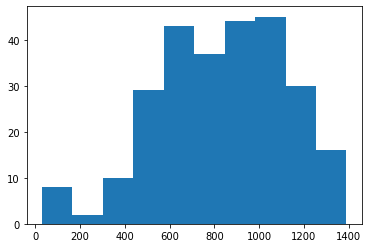

In [48]:
# histogram for lexile levels
plt.hist(labeled_data['Lexiles']);

In [49]:
# normal distribution proofs
labeled_data.describe()

,Lexiles
count,264.000000
mean,829.431818
std,287.330805
min,30.000000
25%,617.500000
50%,860.000000
75%,1040.000000
max,1390.000000


In [121]:
from scipy.stats import skew, kurtosis
mean = labeled_data['Lexiles'].mean()
std = labeled_data['Lexiles'].std()
sort = sorted(labeled_data['Lexiles'])
median = sort[int((len(labeled_data['Lexiles']) / 2))]
mode = labeled_data['Lexiles'].mode()
print(' mean: ', floor(mean), '\n','median: ', floor(median), '\n','mode: ', floor(mode))
print('skewed negatively because median and mode are greater than the mean')
skew_amount = skew(labeled_data['Lexiles'])
print("amount of skew: ", skew_amount, "\n", "That's pretty symmetrical because Fisher-Pearson coefficient of skewness is between -0.5 and 0.5")
kurtosis_amount = kurtosis(labeled_data['Lexiles'])
print("amount of kurtosis: ", kurtosis_amount, "\n", "That's a platykurtic distribution because kurtosis is less than 3")

 mean:  829 
 median:  860 
 mode:  990
skewed negatively because median and mode are greater than the mean
amount of skew:  -0.3956209645966705 
 That's pretty symmetrical because Fisher-Pearson coefficient of skewness is between -0.5 and 0.5
amount of kurtosis:  -0.16849460449323939 
 That's a platykurtic distribution because kurtosis is less than 3


In [127]:
from scipy.stats import normaltest as st
# This is a chi-square test against a normal distribution
skew_squared_plus_kurtosis_squared, pvalue = st(labeled_data['Lexiles'])
reject_null = pvalue < 0.05
print(reject_null)
print('Since the p-value is less than an alpha of 0.05, \n',
      'then we can reject the null hypthosis that this data comes from a normal distribution')
print('This means that we need to transform the data prior to passing it into a model.')

True
Since the p-value is less than an alpha of 0.05, 
 then we can reject the null hypthosis that this data comes from a normal distribution
This means that we need to transform the data prior to passing it into a model.


In [131]:
from scipy.stats import shapiro
test_statistic, pvalue = shapiro(labeled_data['Lexiles'])
reject_null = pvalue < 0.05
print(reject_null)
print('Since this p-value is less than an alpha of 0.05, \n',
      'then we can reject the null hypothesis that this data comes from a normal distribution')

True
Since this p-value is less than an alpha of 0.05, 
 then we can reject the null hypothesis that this data comes from a normal distribution


In [132]:
from scipy.stats import anderson
test_statistic, critical_values, significance_levels = anderson(labeled_data['Lexiles'], dist='norm')

In [133]:
critical_values

array([0.568, 0.646, 0.776, 0.905, 1.076])

In [134]:
significance_levels

array([15. , 10. ,  5. ,  2.5,  1. ])

This Anderson-Darling test shows that we can accept the null hypothesis that this data comes from a normal distribution up to a signficance level of 1 %, seen as the critical values are lower than the signficance levels for 15, 10, 5, and 2.5%. We are looking for a significance level of 5%, an alpha of 0.05, so we can actually accept that this data comes from a normal distribution.

Use a hyperbolic transformation to transform data into normal distribution if required. 

ψ(x, θ) = α sinh(βx)sechλ(βx)/β specifically. If you can't figure that out, then use a box-cox transformation.

In [127]:
# binning data and previewing categories to classifiy into
bins = [0, 650, 1050, 1200, 1400]
labeled_data['Lexiles'] = pd.cut(labeled_data['Lexiles'], bins)
labeled_data['Lexiles'].value_counts(normalize=True)

(650, 1050]     0.473485
(0, 650]        0.287879
(1050, 1200]    0.151515
(1200, 1400]    0.087121
Name: Lexiles, dtype: float64

In [271]:
# generating paragraphs to evaluate based on full texts
tt = TextTilingTokenizer(stopwords=stop_words)
paragraphs = []
para_lexiles = []
para_titles = []
para_texts = []
para_data = pd.DataFrame()
for x in range(0, len(labeled_data['Texts'])):
    print('Generating paragraphs for book number ', x+1)
    paragraph = tt.tokenize(labeled_data['Texts'][x])
    paragraphs.append(paragraph)
    print('Storing information for book')
    for y in range(0, len(paragraph)):
        para_lexiles.append(labeled_data['Lexiles'][x])
        para_titles.append(labeled_data['Titles'][x])
        para_texts.append(paragraph[y])
para_data['Lexiles'] = para_lexiles
para_data['Titles'] = para_titles
para_data['Texts'] = para_texts
para_data.sample(5)

Generating paragraphs for book number  1
Storing information for book
Generating paragraphs for book number  2
Storing information for book
Generating paragraphs for book number  3
Storing information for book
Generating paragraphs for book number  4
Storing information for book
Generating paragraphs for book number  5
Storing information for book
Generating paragraphs for book number  6
Storing information for book
Generating paragraphs for book number  7
Storing information for book
Generating paragraphs for book number  8
Storing information for book
Generating paragraphs for book number  9
Storing information for book
Generating paragraphs for book number  10
Storing information for book
Generating paragraphs for book number  11
Storing information for book
Generating paragraphs for book number  12
Storing information for book
Generating paragraphs for book number  13
Storing information for book
Generating paragraphs for book number  14
Storing information for book
Generating para

Storing information for book
Generating paragraphs for book number  117
Storing information for book
Generating paragraphs for book number  118
Storing information for book
Generating paragraphs for book number  119
Storing information for book
Generating paragraphs for book number  120
Storing information for book
Generating paragraphs for book number  121
Storing information for book
Generating paragraphs for book number  122
Storing information for book
Generating paragraphs for book number  123
Storing information for book
Generating paragraphs for book number  124
Storing information for book
Generating paragraphs for book number  125
Storing information for book
Generating paragraphs for book number  126
Storing information for book
Generating paragraphs for book number  127
Storing information for book
Generating paragraphs for book number  128
Storing information for book
Generating paragraphs for book number  129
Storing information for book
Generating paragraphs for book numb

Storing information for book
Generating paragraphs for book number  231
Storing information for book
Generating paragraphs for book number  232
Storing information for book
Generating paragraphs for book number  233
Storing information for book
Generating paragraphs for book number  234
Storing information for book
Generating paragraphs for book number  235
Storing information for book
Generating paragraphs for book number  236
Storing information for book
Generating paragraphs for book number  237
Storing information for book
Generating paragraphs for book number  238
Storing information for book
Generating paragraphs for book number  239
Storing information for book
Generating paragraphs for book number  240
Storing information for book
Generating paragraphs for book number  241
Storing information for book
Generating paragraphs for book number  242
Storing information for book
Generating paragraphs for book number  243
Storing information for book
Generating paragraphs for book numb

,Lexiles,Titles,Texts
23235,"(1050, 1200]",The Yellow Fairy Book,\n\nSigurd was greatly surprised to hear his Q...
56709,"(650, 1050]",Mike,"\n\n""It might clear before eleven. You'd bette..."
35666,"(650, 1050]",The Black Arrow,"\n\nThe old woman laughed aloud.\n\n""Ah, Maste..."
8986,"(1050, 1200]",Glinda Of Oz,\n\nWhat they saw was more strange than Glinda...
88941,"(650, 1050]",Adaptation,\n\nHe motioned for the servants to remove the...


In [272]:
len(para_data)

102133

In [273]:
para_data['Texts'][22]

'\n\nSeven boys stood in a row all ages, all sizes, all yellow-haired and\nblue-eyed, all in full Scotch costume, and all smiling, nodding, and\nsaying as with one voice, "How are you, cousin?"\n\nRose gave a little gasp, and looked wildly about her as if ready to fly,\nfor fear magnified the seven and the room seemed full of boys. Before\nshe could run, however, the tallest lad stepped out of the line, saying\npleasantly,\n\n"Don\'t be frightened. This is the Clan come to welcome you; and I\'m the\nchief, Archie, at your service."\n\nHe held out his hand as he spoke, and Rose timidly put her own into a\nbrown paw, which closed over the white morsel and held it as the chief\ncontinued his introductions.'

In [19]:
para_data.to_csv('full_text_to_paragraphs.csv')

In [6]:
para_data = pd.read_csv('full_text_to_paragraphs.csv', index_col=0)
para_data.sample(3)

,Lexiles,Titles,Texts
69288,"(1050, 1200]",Anna Karenina,"\n\nWhen the game was over, Stepan Arkadyevitc..."
26868,"(650, 1050]",Anne Of The Island,"\n\n""So's everybody's,"" said Aunt Jamesina che..."
97354,"(1200, 1400]",A Child'S History Of England,\n\nThe intelligence was true. They had been ...


In [5]:
def lemmatize(data):
    '''With raw text data passed in as a single array, will return
    each word with each sentence and its punctuation lemmatized'''
    wnl = WordNetLemmatizer()
    processed = ' '.join(data.splitlines())
    tokens = [word for sent in nltk.sent_tokenize(processed) for word in nltk.word_tokenize(sent)]
    lemmas = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            lemmas.append(wnl.lemmatize(token))
        else:
            lemmas.append(token)
    return lemmas

In [4]:
# lemmatizing data from paragraph inputs
lemmas = []
for x in range(0, len(para_data['Texts'])):
    print('Processing input: ', x+1)
    lemmas.append(lemmatize(para_data['Texts'][x]))

Processing input:  1
Processing input:  2
Processing input:  3
Processing input:  4
Processing input:  5
Processing input:  6
Processing input:  7
Processing input:  8
Processing input:  9
Processing input:  10
Processing input:  11
Processing input:  12
Processing input:  13
Processing input:  14
Processing input:  15
Processing input:  16
Processing input:  17
Processing input:  18
Processing input:  19
Processing input:  20
Processing input:  21
Processing input:  22
Processing input:  23
Processing input:  24
Processing input:  25
Processing input:  26
Processing input:  27
Processing input:  28
Processing input:  29
Processing input:  30
Processing input:  31
Processing input:  32
Processing input:  33
Processing input:  34
Processing input:  35
Processing input:  36
Processing input:  37
Processing input:  38
Processing input:  39
Processing input:  40
Processing input:  41
Processing input:  42
Processing input:  43
Processing input:  44
Processing input:  45
Processing input:  

Processing input:  673
Processing input:  674
Processing input:  675
Processing input:  676
Processing input:  677
Processing input:  678
Processing input:  679
Processing input:  680
Processing input:  681
Processing input:  682
Processing input:  683
Processing input:  684
Processing input:  685
Processing input:  686
Processing input:  687
Processing input:  688
Processing input:  689
Processing input:  690
Processing input:  691
Processing input:  692
Processing input:  693
Processing input:  694
Processing input:  695
Processing input:  696
Processing input:  697
Processing input:  698
Processing input:  699
Processing input:  700
Processing input:  701
Processing input:  702
Processing input:  703
Processing input:  704
Processing input:  705
Processing input:  706
Processing input:  707
Processing input:  708
Processing input:  709
Processing input:  710
Processing input:  711
Processing input:  712
Processing input:  713
Processing input:  714
Processing input:  715
Processing 

Processing input:  1465
Processing input:  1466
Processing input:  1467
Processing input:  1468
Processing input:  1469
Processing input:  1470
Processing input:  1471
Processing input:  1472
Processing input:  1473
Processing input:  1474
Processing input:  1475
Processing input:  1476
Processing input:  1477
Processing input:  1478
Processing input:  1479
Processing input:  1480
Processing input:  1481
Processing input:  1482
Processing input:  1483
Processing input:  1484
Processing input:  1485
Processing input:  1486
Processing input:  1487
Processing input:  1488
Processing input:  1489
Processing input:  1490
Processing input:  1491
Processing input:  1492
Processing input:  1493
Processing input:  1494
Processing input:  1495
Processing input:  1496
Processing input:  1497
Processing input:  1498
Processing input:  1499
Processing input:  1500
Processing input:  1501
Processing input:  1502
Processing input:  1503
Processing input:  1504
Processing input:  1505
Processing input

Processing input:  2099
Processing input:  2100
Processing input:  2101
Processing input:  2102
Processing input:  2103
Processing input:  2104
Processing input:  2105
Processing input:  2106
Processing input:  2107
Processing input:  2108
Processing input:  2109
Processing input:  2110
Processing input:  2111
Processing input:  2112
Processing input:  2113
Processing input:  2114
Processing input:  2115
Processing input:  2116
Processing input:  2117
Processing input:  2118
Processing input:  2119
Processing input:  2120
Processing input:  2121
Processing input:  2122
Processing input:  2123
Processing input:  2124
Processing input:  2125
Processing input:  2126
Processing input:  2127
Processing input:  2128
Processing input:  2129
Processing input:  2130
Processing input:  2131
Processing input:  2132
Processing input:  2133
Processing input:  2134
Processing input:  2135
Processing input:  2136
Processing input:  2137
Processing input:  2138
Processing input:  2139
Processing input

Processing input:  2703
Processing input:  2704
Processing input:  2705
Processing input:  2706
Processing input:  2707
Processing input:  2708
Processing input:  2709
Processing input:  2710
Processing input:  2711
Processing input:  2712
Processing input:  2713
Processing input:  2714
Processing input:  2715
Processing input:  2716
Processing input:  2717
Processing input:  2718
Processing input:  2719
Processing input:  2720
Processing input:  2721
Processing input:  2722
Processing input:  2723
Processing input:  2724
Processing input:  2725
Processing input:  2726
Processing input:  2727
Processing input:  2728
Processing input:  2729
Processing input:  2730
Processing input:  2731
Processing input:  2732
Processing input:  2733
Processing input:  2734
Processing input:  2735
Processing input:  2736
Processing input:  2737
Processing input:  2738
Processing input:  2739
Processing input:  2740
Processing input: 

KeyboardInterrupt: 

In [22]:
# file = open('lemmas.pickle', 'wb')

In [23]:
# pickle.dump(lemmas, file)

In [24]:
# file.close()

In [16]:
file = open('lemmas.pickle', 'rb')

In [17]:
lemmas = pickle.load(file)

In [18]:
file.close()

In [10]:
# longest entry
lengths = []
for i in range(0, len(lemmas)):
    lengths.append(len(lemmas[i]))
lengths.sort()
lengths[-5:-1]

[1374, 1484, 1509, 1592]

In [21]:
# prepping for neural network
# Initialize a tokenizer
tokenizer = Tokenizer()
tokenizer.num_words=10000 
tokenizer.oov_token='nothere'
# Fit it to the complaints
tokenizer.fit_on_texts(lemmas) 
# Generate sequences
sequences = tokenizer.texts_to_sequences(lemmas) 
print('sequences type:', type(sequences))

# take sequences and pad to longest length
padded = pad_sequences(sequences, maxlen=1592)

# Similar to sequences, but returns a numpy array
one_hot_results= tokenizer.texts_to_matrix(lemmas, mode='tfidf') 
print('one_hot_results type:', type(one_hot_results))
# Useful if we wish to decode (more explanation below)
word_index = tokenizer.word_index
# Tokens are the number of unique words across the corpus
print('Found %s unique tokens.' % len(word_index))
# Our coded data
print('Dimensions of our coded results:', np.shape(one_hot_results)) 

sequences type: <class 'list'>
one_hot_results type: <class 'numpy.ndarray'>
Found 112389 unique tokens.
Dimensions of our coded results: (102133, 10000)


In [390]:
# file = open('tokenizer.pickle', 'wb')

In [391]:
# pickle.dump(tokenizer, file)

In [392]:
# file.close()

In [10]:
file = open('tokenizer.pickle', 'rb') 

In [11]:
tokenizer = pickle.load(file)

In [12]:
file.close()

In [22]:
# for decoding word vectors
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

In [23]:
# example of decoding word vectors
paragraph_idx_to_preview = 3000
print('Original text:')
print(' '.join(lemmas[paragraph_idx_to_preview]))
print('\n\n')

# The reverse_index cell block above must be complete in order for this cell block to successively execute 
decoded_review = ' '.join([reverse_index.get(i) for i in sequences[paragraph_idx_to_preview]])
print('Decoded review from Tokenizer:')
print(decoded_review)

Original text:
`` How ? '' and Nan sat up with a face full of interest . `` I had a new pair of shoe once , and wanted to show them ; so , though I wa told not to leave the garden , I ran away and wa wandering about all day . It wa in the city , and why I wa n't killed I do n't know . Such a time a I had . I frolicked in the park with dog , sailed boat in the Back Bay with strange boy , dined with a little Irish beggar-girl on salt fish and potato , and wa found at last fast asleep on a door-step with my arm round a great dog . It wa late in the evening , and I wa a dirty a a little pig , and the new shoe were worn out I had travelled so far . '' `` How nice ! '' cried Nan , looking all ready to go and do it herself . `` It wa not nice next day ; '' and Mrs. Jo tried to keep her eye from betraying how much she enjoyed the memory of her early caper . `` Did your mother whip you ? '' asked Nan , curiously . `` She never whipped me but once , and then she begged my pardon , or I do n't th

In [24]:
lexiles = para_data['Lexiles']

# Initialize
le = LabelEncoder() 
le.fit(lexiles)
print('Original class labels:')
print(list(le.classes_))
print('\n')
lexile_cat = le.transform(lexiles)  

# If you wish to retrieve the original descriptive labels post production
# list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) 

print('New product labels:')
print(lexile_cat)
print('\n')

# Each row will be all zeros except for the category for that observation 
print('One hot labels; 4 binary columns, one for each of the categories.') 
lexile_onehot = to_categorical(lexile_cat)
print(lexile_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(lexile_onehot))

Original class labels:
['(0, 650]', '(1050, 1200]', '(1200, 1400]', '(650, 1050]']


New product labels:
[1 1 1 ... 1 1 1]


One hot labels; 4 binary columns, one for each of the categories.
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


One hot labels shape:
(102133, 4)


In [25]:
lexile_onehot[0]

array([0., 1., 0., 0.], dtype=float32)

In [102]:
# file = open('labels.pickle', 'wb')

In [103]:
# pickle.dump(list(le.classes_), file)

In [104]:
# file.close()

In [6]:
file = open('labels.pickle', 'rb')

In [7]:
classes = pickle.load(file)

In [8]:
file.close()

In [26]:
test_percentage = float(np.shape(lexile_onehot)[0])*0.2
random.seed(123)
test_index = random.sample(range(1,np.shape(lexile_onehot)[0]), floor(test_percentage))

test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

label_test = lexile_onehot[test_index]
label_train = np.delete(lexile_onehot, test_index, 0)

print('Test label shape:', np.shape(label_test))
print('Train label shape:', np.shape(label_train))
print('Test shape:', np.shape(test))
print('Train shape:', np.shape(train))

Test label shape: (20426, 4)
Train label shape: (81707, 4)
Test shape: (20426, 10000)
Train shape: (81707, 10000)


<a href='#Background'>Back to top</a>

# Model

-- importance of normal data for neural networks

sgd destroys any normalization done prior to passing in data, however, there is a such thing as a self-normalizing neural network that normalizes data as it moves through each layer in the network using the acitvation called "SELU".

" For the activation function, we propose “scaled exponential linear units” (SELUs) to render a FNN (feed-forward neural network, moving from one node to the next) as self-normalizing. 
The SELU activation function is given by:

<center>$ selu(x) = λ \begin{cases} 
    x &\text {if x > 0},\\
    αe^{x} − α&\text {if x <= 6}." 
    \end{cases}$</center>
    
There's a SELU function in tensorflow, and in keras now.

In [ ]:
# regression (do not one hot encode)
# Initialize a sequential model
model = models.Sequential()
# Layers with relu activation
model.add(layers.Dense(128, activation='selu', input_shape=(5000,)))
model.add(layers.Dense(64, activation='selu'))
# One layer with softmax activation 
model.add(layers.Dense(1, activation='linear'))

In [ ]:
# Compile the model
model.compile(optimizer='SGD', 
              loss='mse', 
              metrics=['accuracy'])

In [ ]:
# Train the model 
history = model.fit(train,
                    label_train,
                    epochs=100,
                    batch_size=256)

In [192]:
from keras.layers import Dropout, GaussianNoise

## Neural Network

In [47]:
# Initialize a sequential model
model = models.Sequential()

# add lstm layers (if going to a second lstm, set return sequences to true)

# Layers with selu activation
model.add(layers.Dense(1028, activation='selu', input_shape=(10000,)))
model.add(layers.Dense(512, activation='selu'))
model.add(layers.Dense(128, activation='selu'))
model.add(layers.Dense(32, activation='selu'))
# One layer with softmax activation 
model.add(layers.Dense(4, activation='softmax'))

In [48]:
# Compile the model
model.compile(optimizer='SGD', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [49]:
# Train the model 
history = model.fit(train,
                    label_train,
                    epochs=175,
                    batch_size=4112)

Epoch 1/175
81707/81707 [==============================] - 12s 143us/step - loss: 2.4012 - accuracy: 0.3181
Epoch 2/175
81707/81707 [==============================] - 10s 126us/step - loss: 1.3195 - accuracy: 0.3891
Epoch 3/175
81707/81707 [==============================] - 11s 136us/step - loss: 1.2572 - accuracy: 0.4331
Epoch 4/175
81707/81707 [==============================] - 10s 127us/step - loss: 1.2144 - accuracy: 0.4582
Epoch 5/175
81707/81707 [==============================] - 10s 124us/step - loss: 1.1942 - accuracy: 0.4668
Epoch 6/175
81707/81707 [==============================] - 10s 125us/step - loss: 1.1530 - accuracy: 0.4914
Epoch 7/175
81707/81707 [==============================] - 10s 126us/step - loss: 1.1345 - accuracy: 0.5082
Epoch 8/175
81707/81707 [==============================] - 10s 125us/step - loss: 1.1055 - accuracy: 0.5255
Epoch 9/175
81707/81707 [==============================] - 10s 125us/step - loss: 1.0735 - accuracy: 0.5432
Epoch 10/175
81707/81707 [==

81707/81707 [==============================] - 10s 119us/step - loss: 0.3070 - accuracy: 0.8790
Epoch 151/175
81707/81707 [==============================] - 10s 119us/step - loss: 0.3457 - accuracy: 0.8680
Epoch 152/175
81707/81707 [==============================] - 10s 119us/step - loss: 0.3142 - accuracy: 0.8794
Epoch 153/175
81707/81707 [==============================] - 10s 121us/step - loss: 0.3307 - accuracy: 0.8697
Epoch 154/175
81707/81707 [==============================] - 10s 122us/step - loss: 0.3206 - accuracy: 0.8748
Epoch 155/175
81707/81707 [==============================] - 10s 122us/step - loss: 0.3204 - accuracy: 0.8771
Epoch 156/175
81707/81707 [==============================] - 10s 120us/step - loss: 0.3215 - accuracy: 0.8749
Epoch 157/175
81707/81707 [==============================] - 10s 122us/step - loss: 0.3112 - accuracy: 0.8795
Epoch 158/175
81707/81707 [==============================] - 10s 123us/step - loss: 0.3137 - accuracy: 0.8803
Epoch 159/175
81707/8170

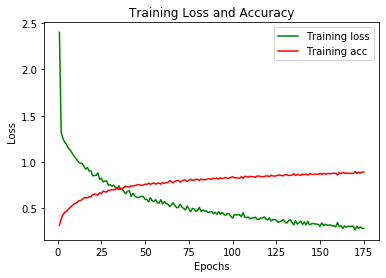

In [50]:
# Plot the loss vs the number of epoch
history_dict = history.history # save
loss_values = history_dict['loss']
acc_values = history_dict['accuracy'] 

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, acc_values, 'r', label='Training acc')

plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot the loss vs the number of epoch
history_dict = history.history # save
loss_values = history_dict['loss']
acc_values = history_dict['accuracy'] 

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, acc_values, 'r', label='Training acc')

plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# output for train set
y_hat_train = model.predict(train)

In [23]:
# Output (probability) predictions for the test set 
y_hat_test = model.predict(test)
len(y_hat_test)

20426

In [24]:
# Print the loss and accuracy for the training set 
results_train = model.evaluate(train, label_train)
results_train

81707/81707 [==============================] - 14s 170us/step


[0.24616399902655203, 0.9096160531044006]

In [25]:
# Print the loss and accuracy for the test set 
results_test = model.evaluate(test, label_test)
results_test

20426/20426 [==============================] - 3s 170us/step


[0.4839462114281534, 0.821159303188324]

In [26]:
model.metrics_names

['loss', 'accuracy']

In [30]:
le.classes_

array(['(0, 650]', '(1050, 1200]', '(1200, 1400]', '(650, 1050]'],
      dtype=object)

In [34]:
[np.argmax(x) for x in label_test]

[0,
 0,
 3,
 3,
 0,
 3,
 0,
 2,
 2,
 2,
 2,
 3,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 3,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 2,
 1,
 1,
 3,
 2,
 1,
 3,
 2,
 1,
 2,
 3,
 3,
 1,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 3,
 0,
 3,
 3,
 0,
 1,
 3,
 3,
 2,
 3,
 0,
 3,
 0,
 1,
 3,
 1,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 0,
 0,
 3,
 1,
 1,
 1,
 2,
 3,
 1,
 2,
 1,
 3,
 3,
 1,
 1,
 1,
 3,
 0,
 3,
 3,
 0,
 0,
 0,
 3,
 0,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 0,
 2,
 1,
 3,
 1,
 3,
 0,
 0,
 3,
 3,
 0,
 1,
 1,
 0,
 0,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 0,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 3,
 0,
 3,
 3,
 3,
 0,
 2,
 1,
 1,
 0,
 1,
 3,
 0,
 1,
 1,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 2,
 3,
 3,
 0,
 0,
 1,
 3,
 2,
 0,
 3,
 2,
 3,
 0,
 1,
 3,
 0,
 3,
 2,
 1,
 1,
 1,
 3,
 1,
 0,
 3,
 3,
 3,
 3,
 2,
 1,
 3,
 1,
 0,
 1,
 2,
 3,
 0,
 0,
 3,
 1,
 0,
 3,
 3,
 3,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 3,
 2,
 0,
 0,
 3,
 3,
 1,
 1,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 2,
 2,
 1,


In [32]:
[np.argmax(x) for x in y_hat_test]

[3,
 0,
 3,
 0,
 0,
 3,
 0,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 3,
 3,
 3,
 3,
 2,
 1,
 1,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 1,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 1,
 1,
 0,
 3,
 2,
 1,
 1,
 1,
 3,
 0,
 3,
 3,
 0,
 1,
 3,
 3,
 2,
 3,
 3,
 3,
 0,
 1,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 0,
 0,
 3,
 1,
 1,
 1,
 2,
 3,
 0,
 1,
 1,
 3,
 3,
 1,
 1,
 3,
 1,
 0,
 3,
 3,
 0,
 0,
 0,
 3,
 1,
 1,
 2,
 3,
 3,
 1,
 3,
 3,
 0,
 0,
 0,
 3,
 3,
 0,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 3,
 0,
 0,
 3,
 3,
 1,
 1,
 1,
 0,
 0,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 0,
 2,
 0,
 3,
 2,
 0,
 3,
 0,
 1,
 0,
 3,
 3,
 1,
 0,
 2,
 1,
 1,
 0,
 1,
 3,
 0,
 1,
 1,
 1,
 0,
 3,
 3,
 0,
 3,
 3,
 2,
 1,
 3,
 0,
 0,
 1,
 3,
 2,
 0,
 3,
 2,
 3,
 0,
 1,
 3,
 0,
 3,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 3,
 3,
 0,
 2,
 1,
 3,
 1,
 0,
 1,
 3,
 3,
 0,
 0,
 0,
 1,
 0,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 3,
 2,
 3,
 2,
 3,
 0,
 3,
 1,
 1,
 3,
 1,
 0,
 3,
 3,
 0,
 3,
 3,
 2,
 2,
 1,


In [37]:
from sklearn.metrics import multilabel_confusion_matrix

In [46]:
cm = multilabel_confusion_matrix([np.argmax(x) for x in label_test], [np.argmax(x) for x in y_hat_test])

In [47]:
cm

array([[[14310,   788],
        [ 1078,  4250]],

       [[15268,   893],
        [  783,  3482]],

       [[17369,   170],
        [  895,  1992]],

       [[10678,  1802],
        [  897,  7049]]], dtype=int64)

In [51]:
le.classes_

array(['(0, 650]', '(1050, 1200]', '(1200, 1400]', '(650, 1050]'],
      dtype=object)

In [40]:
plt.set_cmap('YlGn');

<Figure size 432x288 with 0 Axes>

In [41]:
import seaborn as sns

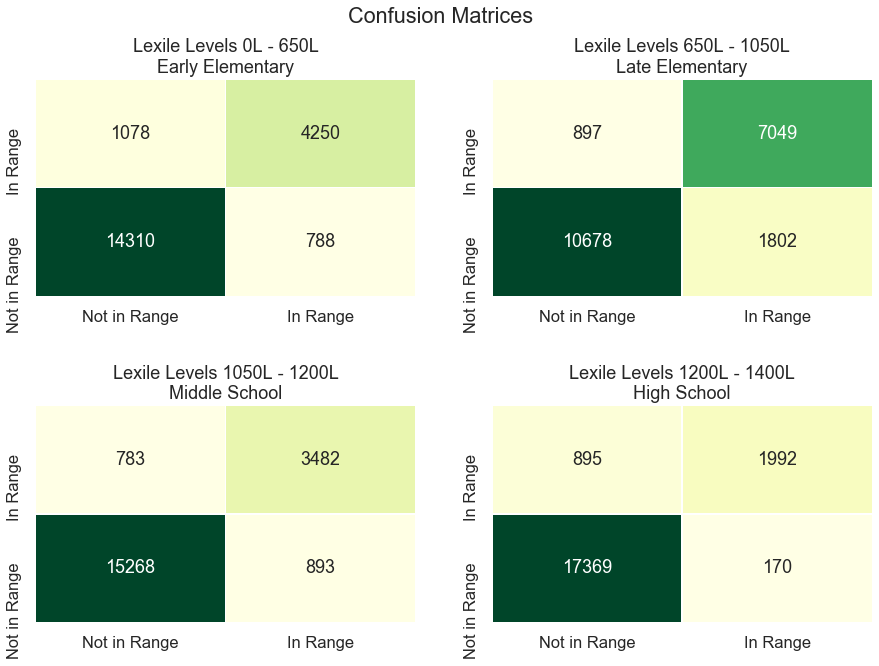

In [229]:
fig = plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
annot_kwords={'verticalalignment':'top', 'horizontalalignment':'center'};

plt.subplot(2,2,1) # first heatmap
ax = sns.heatmap(cm[0,:,:], annot=True, xticklabels=['Not in Range','In Range'], yticklabels=['Not in Range','In Range'], fmt='d', linewidths=.5, cmap="YlGn", cbar=False, annot_kws=annot_kwords)
ax.set_ylim([0,2])
ax.set_title('Lexile Levels 0L - 650L\nEarly Elementary')
 
plt.subplot(2,2,2) # second heatmap
ax = sns.heatmap(cm[3,:,:], annot=True, xticklabels=['Not in Range','In Range'], yticklabels=['Not in Range','In Range'], fmt='d', linewidths=.5, cmap="YlGn", cbar=False, annot_kws=annot_kwords)
ax.set_ylim([0,2])
ax.set_title('Lexile Levels 650L - 1050L\nLate Elementary')
plt.subplots_adjust(hspace=.5)
 
plt.subplot(2,2,3) # third heatmap
ax = sns.heatmap(cm[1,:,:], annot=True, xticklabels=['Not in Range','In Range'], yticklabels=['Not in Range','In Range'], fmt='d', linewidths=.5, cmap="YlGn", cbar=False, annot_kws=annot_kwords)
ax.set_ylim([0,2])
ax.set_title('Lexile Levels 1050L - 1200L\nMiddle School')

plt.subplot(2,2,4) # fourth heatmap
ax = sns.heatmap(cm[2,:,:], annot=True, xticklabels=['Not in Range','In Range'], yticklabels=['Not in Range','In Range'], fmt='d', linewidths=.5, cmap="YlGn", cbar=False, annot_kws=annot_kwords)
ax.set_ylim([0,2])
ax.set_title('Lexile Levels 1200L - 1400L\nHigh School')

fig.suptitle('Confusion Matrices')

plt.show()

In [137]:
probabilities = model.predict_proba(test)

In [154]:
probabilities[0]

array([0.01979834, 0.05893867, 0.05943189, 0.86183107], dtype=float32)

In [159]:
np.argmax(label_test[0])

0

In [175]:
y_hat_test[0][np.argmax(y_hat_test[0])]

0.86183107

In [220]:
mismatch_count = 0
second_match_count = 0
for x in range(0, len(label_test)):
    if np.argmax(label_test[x]) != np.argmax(y_hat_test[x]):
        mismatch_count = mismatch_count + 1
        new_probs = []
        for i in range(0, len(y_hat_test[x])):
            if y_hat_test[x][np.argmax(y_hat_test[x])] != y_hat_test[x][i]:
                new_probs.append(y_hat_test[x][i])
        if le.classes_[np.argmax(label_test[x])] == le.classes_[np.argmax(new_probs)]:
            second_match_count = second_match_count + 1
print('Error rate: ', mismatch_count / len(y_hat_test) * 100)
print('Percentage of time second match is right within error rate: ', second_match_count / mismatch_count * 100)

Error rate:  17.88406932341134
Percentage of time second match is right within error rate:  40.76101834108952


In [41]:
#save model
model.save('model.h5')

In [19]:
# load model
model = load_model('model.h5')

## Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
clf = RandomForestClassifier(min_samples_leaf=50, oob_score=True, n_jobs=12, random_state=0, verbose=1)
clf.fit(train, label_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   24.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=12, oob_score=True, random_state=0, verbose=1,
                       warm_start=False)

In [29]:
clf.score(test, label_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


0.19401742876725742

In [34]:
label_train_pred = clf.predict(train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished


In [30]:
label_test_pred = clf.predict(test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


In [31]:
from sklearn.metrics import accuracy_score as acc

In [35]:
train_accuracy = acc(label_train, label_train_pred)
train_accuracy

0.20333631145434294

In [33]:
test_accuracy = acc(label_test, label_test_pred)
test_accuracy

0.19401742876725742

In [38]:
cm = multilabel_confusion_matrix([np.argmax(x) for x in label_test], [np.argmax(x) for x in label_test_pred])

In [39]:
cm

array([[[ 3205, 11893],
        [  222,  5106]],

       [[16082,    79],
        [ 3681,   584]],

       [[17539,     0],
        [ 2768,   119]],

       [[12180,   300],
        [ 5601,  2345]]], dtype=int64)

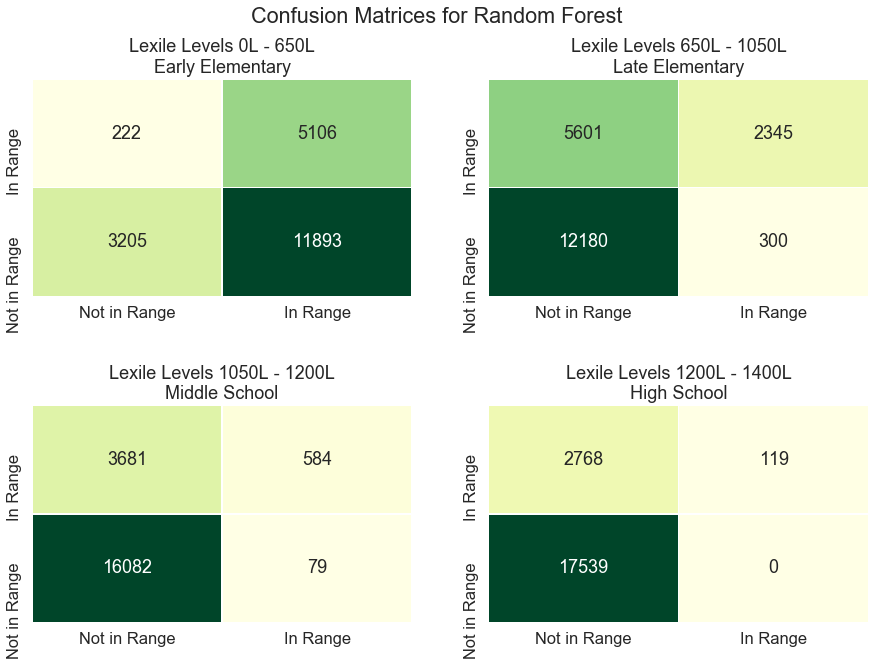

In [43]:
fig = plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
annot_kwords={'verticalalignment':'top', 'horizontalalignment':'center'};

plt.subplot(2,2,1) # first heatmap
ax = sns.heatmap(cm[0,:,:], annot=True, xticklabels=['Not in Range','In Range'], yticklabels=['Not in Range','In Range'], fmt='d', linewidths=.5, cmap="YlGn", cbar=False, annot_kws=annot_kwords)
ax.set_ylim([0,2])
ax.set_title('Lexile Levels 0L - 650L\nEarly Elementary')
 
plt.subplot(2,2,2) # second heatmap
ax = sns.heatmap(cm[3,:,:], annot=True, xticklabels=['Not in Range','In Range'], yticklabels=['Not in Range','In Range'], fmt='d', linewidths=.5, cmap="YlGn", cbar=False, annot_kws=annot_kwords)
ax.set_ylim([0,2])
ax.set_title('Lexile Levels 650L - 1050L\nLate Elementary')
plt.subplots_adjust(hspace=.5)
 
plt.subplot(2,2,3) # third heatmap
ax = sns.heatmap(cm[1,:,:], annot=True, xticklabels=['Not in Range','In Range'], yticklabels=['Not in Range','In Range'], fmt='d', linewidths=.5, cmap="YlGn", cbar=False, annot_kws=annot_kwords)
ax.set_ylim([0,2])
ax.set_title('Lexile Levels 1050L - 1200L\nMiddle School')

plt.subplot(2,2,4) # fourth heatmap
ax = sns.heatmap(cm[2,:,:], annot=True, xticklabels=['Not in Range','In Range'], yticklabels=['Not in Range','In Range'], fmt='d', linewidths=.5, cmap="YlGn", cbar=False, annot_kws=annot_kwords)
ax.set_ylim([0,2])
ax.set_title('Lexile Levels 1200L - 1400L\nHigh School')

fig.suptitle('Confusion Matrices for Random Forest')

plt.show()

<a href='#Background'>Back to top</a>

# Results <a id='Results'></a>

The model generated has a training accuracy of 90% and testing accuracy of 81%. This model was saved and used to generate a Flask application that has been deployed locally.

This project accomplished the purpose set out of identifying what lexile level any text is by copy/pasting an input to a webpage designed for the task at a satisfactory rate of 81% accuracy. Also, the category selected as second best yielded an additional 40% correct.

<a href='#Background'>Back to top</a>

# Deployment <a id='Deployment'></a>

In [3]:
def initialize():
    '''Loads model and tokenizer.'''

    # load model
    model = load_model('model.h5')

    # load tokenizer
    file = open('tokenizer.pickle', 'rb') 
    tokenizer = pickle.load(file)
    
    return model, tokenizer

In [4]:
def lemmatize(data):
    '''With raw text data passed in as a single array, will return
    each word with each sentence and its punctuation lemmatized'''
    wnl = WordNetLemmatizer()
    processed = ' '.join(data.splitlines())
    tokens = [word for sent in nltk.sent_tokenize(processed) for word in nltk.word_tokenize(sent)]
    lemmas = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            lemmas.append(wnl.lemmatize(token))
        else:
            lemmas.append(token)
    return lemmas

In [5]:
def preprocessing(para):
    '''Loads stopwords to be used, splits data up into managable chunks for the model, 
    lemmatizes input data, and vectorizes data.'''
    
    # loading stopwords (combination of elizabethan stopwords and nltk's english stopwords)
    file = open('stopwords.pickle', 'rb')
    stop_words = pickle.load(file)

    # generating paragraphs to evaluate based on full texts
    tt = TextTilingTokenizer(stopwords=stop_words)

    # ensure data passed in is a string
    para = str(para)
    
    try:
        # splitting data into smaller bits to pass into model
        print('Splitting input.')
        paragraph = tt.tokenize(para)
        # text processing -lemmatizing to pass into model
        print('Processing input.')
        lemmas = lemmatize(paragraph)
    except ValueError:
        # text processing -lemmatizing to pass into model
        print('Processing input.')
        lemmas = lemmatize(para)

    print('Returning data.')
    # vectoring
    one_hot_results= tokenizer.texts_to_matrix([lemmas], mode='tfidf') 

    return one_hot_results

In [6]:
model, tokenizer = initialize()

In [7]:
fake_para = 'Keras is a simple and powerful Python library for deep learning.\nGiven that deep learning models can take hours, days and even weeks to train, it is important to know how to save and load them from disk.\nIn this post, you will discover how you can save your Keras models to file and load them up again to make predictions.'

In [8]:
science_art = 'Scientists have resurrected a purple-blue hue that had been lost to time.\nCalled folium, this watercolor had been used to paint images on the pages of medieval manuscripts. But long ago, it fell out of use. Now scientists have tracked down folium’s source to a plant. They’ve also mapped out the molecule that produces its blue hue./nSuch chemical information can be key to conserving art. “We want to mimic these ancient colors to know how to … preserve them,” explains Maria Melo. She works at Universidade Nova de Lisboa in Caparica, Portugal. There she studies ancient art and how to preserve or restore it. To unmask folium’s identity, her team had to first find out where it came from./nThe pigment hadn’t been used for centuries. Everyone who knew how to prepare it had died long ago. So the researchers turned to books from the 1400’s and found one that described the plant that was its source. That led them on a scavenger hunt to find living specimens of this plant.'

In [9]:
def model_predict(text):
    '''Passes preprocessed text into model and classifies text, returning approximate lexile level.'''
    file = open('labels.pickle', 'rb')
    classes = pickle.load(file)
    file.close()
    for index, value in enumerate(model.predict(preprocessing(text))[0]):
        if value > 0.70:
            print('Lexile Found!')
            found_lexile = classes[index]
            if found_lexile == classes[0]:
                to_post = 'This text is suitable for early elemetary aged readers. The lexile range for this text is from 0 to 650L.'
            elif found_lexile == classes[3]:
                to_post = 'This text is suitable for late elementary aged readers. The lexile range for this text is from 650L to 1050L.'
            elif found_lexile == classes[1]:
                to_post = 'This text is suitable for middle school aged readers. The lexile range for this text is from 1050L to 1200L.'
            else:
                to_post = 'This text is suitable for high school aged readers. The lexile range for this text is from 1200L to 1400L.'
            break
        elif value > 0.3:
            found_lexile = classes[index]
            if found_lexile == classes[0]:
                to_post = 'This text is most similar to texts suitable for early elemetary aged readers. The lexile match is closet to the range 0 to 650L.'
            elif found_lexile == classes[3]:
                to_post = 'This text is most similar to texts suitable for late elementary aged readers. The lexile match is closet to the range 650L to 1050L.'
            elif found_lexile == classes[1]:
                to_post = 'This text is most similar to texts suitable for middle school aged readers. The lexile match is closet to the range 1050L to 1200L.'
            else:
                to_post = 'This text is most similar to texts suitable for high school aged readers. The lexile match is closet to the range 1200L to 1400L.'
            break
        elif index > 3:
            to_post = 'No lexile match'
        else:
            print('Reevaluating.')
    return to_post

In [10]:
model_predict(science_art)

Splitting input.
Processing input.
Returning data.
Reevaluating.
Lexile Found!


'This text is suitable for middle school aged readers. The lexile range for this text is from 1050L to 1200L.'

In [212]:
more_science_art='They enlisted the help of a botanist, a scientist who studies plants. The team landed on Chrozophora tinctoria (Croh-ZOFF-or-uh Tink-TOR-ee-uh). They found this tiny herb with silvery-green leaves in a village in south Portugal. It was growing along roadsides and in fields after harvest. The team gathered its pebble-sized fruit with care.\nBack in the lab, the scientists extracted the pigment with the help of a medieval text on colors. “It’s very specific,” notes Paula Nabais. She’s a conservation scientist who was part of the research team. “So we were able to use that recipe [and] reproduce it.” Nabais also works at Universidade Nova de Lisboa.\n“That’s pretty cool to have done that work of looking in the historical recipes and traveling back in time,” says Francesca Casadio. She’s a chemist and museum scientist at the Art Institute of Chicago in Illinois. Casadio, who was not part of this study, says the new work is a good example of what’s called experimental archaeology. It recreates an ancient process. By making the dye, the scientists could study its chemistry without experimenting on priceless works of art, she points out.\nThe researchers used many techniques to analyze the dye and identify its chemical structure. They reported how they did it April 17 in Science Advances. They also simulated how light interacts with the candidate molecule. That helped the scientists check whether the structure would give them the blue they desired.\nKnowing a paint’s chemistry helps conservation scientists know how to preserve art that used it. For instance, these data might be used to slow a paint’s degradation. Or if the piece needs to be restored, museum scientists can find compatible pigments. “This is absolutely vital to conservation,” says Mark Clarke. He’s a conservation scientist at Universidade Nova de Lisboa. He was not part of this team but has studied folium before.\nFolium had presented scientists with a difficult chemistry puzzle. “People have been tinkering with [this dye] since the ‘30s and they’ve finally cracked it,” he says.\nThis team succeeded because it brought together experts from fields as diverse as chemistry, botany and medieval literature. In the end, Clarke says, you’ve got “new science from old books.” And, he adds, these very modern things are being used to answer “very old problems.”'

In [213]:
model_predict(science_art + more_science_art)

Splitting input.
Processing input.
Returning data.
Reevaluating.
Lexile Found!


'This text is suitable for middle school aged readers. The lexile range for this text is from 1050L to 1200L.'

In [214]:
bubbles = 'Bubbles are everywhere. You just need to know where to look. There’s the obvious place — the soap bubbles in your bath. There are also bubbles in your body. They’re responsible for your cracking knuckles. The gems in a ring might have bubbles, called inclusions. Going farther out, humpback whales use bubbles to hunt. And scientists figured out a way to heal wounds with bubbles.\nBut the best bubbles, at least on a sunny summer day, are probably the bubbles you blow in your own backyard. Scientists have found these bubbles to be alluring, too. They’ve figured out the best way to blow perfect bubbles, and the secret recipe for making huge ones. They’ve also listened in on bubble bursts to figure out the physics that underlie the gentle “pfttt” that accompanies a bubble’s demise.'

In [215]:
model_predict(bubbles)

Splitting input.
Processing input.
Returning data.
Reevaluating.
Lexile Found!


'This text is suitable for middle school aged readers. The lexile range for this text is from 1050L to 1200L.'

In [216]:
science_method = "The basic scientific method includes the steps scientists use and follow when trying to solve a problem or prove or disprove a theory. The methods are used by scientists all over the world. This is done so scientists can work together to solve some of the same problems.\nThere are usually five steps which are a part of the scientific method. The steps can occur in any order, but the first step is usually observation. An observation is the use of one or more of the five senses, which include seeing, hearing, feeling, smelling, and tasting. The five senses are used to learn about or identify an event or object the scientist wants to study. For example, while observing a spider a scientist may observe the pattern or size of the spider's web.\nThe second step of the scientific method is the question being researched, the hypothesis. It is the question that is turned into a statement about an event or object the scientist would like to research. A good hypothesis includes three things: The explanation for the observations, it is able to be tested by other scientists, and it will usually predict new outcomes or conclusions. The scientist observing the spider building the web may have a question about the strength of the web. An example of the hypothesis might be: The larger the spider, the stronger the web. This hypothesis includes the explanation for the observation, it can be tested, and new conclusions may be reached.\nThe third step of the scientific method is the experiment. An experiment is a test which will either challenge or support the hypothesis. The hypothesis will then be true or false. Using the spider hypothesis, a scientist may experiment by measuring spider webs in relation to a spider's size. Often, even when a hypothesis is disproved much can still be learned during the experiment. For example, while measuring the strength of spider webs the scientist may discover something new about them.\nThe final step in the scientific method is the conclusion. The conclusion will either clearly support the hypothesis or it will not. If the results support the hypothesis a conclusion can be written. If it does not support the hypothesis, the scientist may choose to change the hypothesis or write a new one based on what was learned during the experiment. In the example, if the scientist proves that larger spiders build stronger webs, then that is the conclusion. If it was not proven, the scientist may change the hypothesis to: The size of a spider does has no bearing on the strength of its web.\nThe scientific method is used for simple experiments students may do in the classroom or very complex or difficult experiments being done all over the world. The spider experiment may be done by any scientist in the world.\nIn summary, the scientific method includes the steps scientists use to solve a problem or to prove or disprove a theory. There are four basic steps involved with the scientific method. The usual steps include observation, hypothesis, experiment, and conclusion. The steps may not always be completed in the same order. Following the four steps, the results of the experiment will either support the hypothesis or will not support the hypothesis. Scientists are always free to change or write a new hypothesis and start the four steps all over again. The scientific method is used for simple experiments or for more difficult experiments."

In [217]:
model_predict(science_method)

Splitting input.
Processing input.
Returning data.
Lexile Found!


'This text is suitable for early elemetary aged readers. The lexile range for this text is from 0 to 650L.'

In [218]:
evolution = "In 1859, Charles Darwin published convincing evidence that species evolve. He further explained how this process occurs. From that evidence and explanation, we have what scientists and others call today, the Theory of Evolution.\nLike all scientific theories, the theory of evolution has developed through decades of scientific observations and experimentation. Today almost all scientists accept that evolution is the basis for the diversity of life on earth.\nAfter years of research and study, Darwin suggested that by surviving long enough to reproduce, populations have the opportunity to pass on favorable characteristics to offspring. Over time, these characteristics will increase in a population and the nature of that population will gradually change. Darwin called this process by which populations change in response to their environment natural selection.\nDarwin suggested that organisms differ from place to place because their habitats present different challenges to survival and reproduction. As a result, each species has evolved in response to their specific environment. This changing process in response to a particular environment is called adaption. Darwin concluded that the species in a particular place evolved from a species that previously lived there or that migrated from a nearby area.\nDarwin's evidence was based on the idea that in any population, individuals that are best suited to survive and do well in their environment will produce the most offspring. By doing so, the traits of that offspring will be passed on and become more common as each new generation arrives. Traits are the genetic characteristics that may be physical, such as hair color; or behavioral, such as birds building nests.'nScientist now know that genes are responsible for inherited traits. Therefore, certain forms of a trait become more common because more of the species carry the gene that is passed on. In other words, natural selection causes the frequency of genes in a population to increase or decrease over time.\nFossils offer the most direct evidence that evolution takes place. A fossil is the preserved or mineralized remains or imprint of an organism that lived past life-forms. Change over time, or evolution can be seen in the fossils. For example, fossil links have been found between fish and amphibians, between retiles and birds, and between reptiles and mammals. All of which add valuable evidence to the history of vertebrates./nToday, Darwin's theory of evolution is almost universally accepted by scientists as the best available explanation for the biological diversity on earth. Based on this supporting evidence, most scientist agree on the following three major points: 1) Earth is about 4.5 billion years old, 2) Organisms have inhabited earth for most of its history, and 3) All organisms living today evolved from earlier, simpler life-forms.\nIn summary, at age 22, Charles Darwin set off on a journey by the urging of his college professor on the naval voyage of the HMS Beagle that forever changed his life and the way people think of themselves. It was on this journey that evidence was collected to support what is universally accepted today as Darwin's Theory of Evolution."

In [219]:
model_predict(evolution)

Splitting input.
Processing input.
Returning data.
Lexile Found!


'This text is suitable for early elemetary aged readers. The lexile range for this text is from 0 to 650L.'

In [220]:
corona = "A letter, published in The New England Journal of Medicine (NEJM), warns of new-onset diabetes in COVID-19 patients.\nDr Abd Tahrani, Senior Lecturer in Metabolic Endocrinology and Obesity Medicine and NIHR Clinician Scientist; University of Birmingham, said:\,“The current evidence suggest that diabetes and poor glycaemic control are risk factors for severe COVID-19 and that COVID-19 might precipitate diabetes-related ketoacidosis. However, whether COVID-19 can increase the risk of developing diabetes mellitus remains unknown and the correspondence published at NEJM provides plausible mechanisms for a bi-directional relationship between diabetes and COVID-19. Hence, it is important to examine these complex interactions between diabetes and COVID-19 further and the setting up of the global registry CoviDIAB is an important step in that regards. However, for now and till further evidence is available, it is important that we improve glycaemic control in people with diabetes to reduce the risk of severe COVID-19 as well as working on strategies that prevent the development of Type 2 diabetes.  An essential step in that direction is treating people with obesity and making obesity treatments (from life style interventions to bariatric surgery) available to patients with obesity that require treatment nationally as current treatment option availability is post code lottery.” \nDr Gabriela da Silva Xavier, Senior Lecturer in Cellular Metabolism, University of Birmingham, said:\n“The three papers that were cited to support the need for further research represents one case study describing the case of one patient with new onset diabetes and two papers describing larger cohorts with diabetes where the disease may have been aggravated by COVID-19.  None of the studies cited explicitly describe diabetes brought on by COVID-19.\n“One of the cited papers provides circumstantial evidence for potential damage of the cells that produce insulin, the pancreatic beta cells, by SARS, not COVID-19.\n“Taken together, it is currently unclear whether COVID-19 is causal for diabetes, but there is some correlation with worsening of disease with COVID-19.  It is, therefore, logical to want to investigate whether COVID-19 is causal for or exacerbates diabetes by establishing a registry where patient history of diabetes is systematically logged, as proposed in the letter. \n“In short it would be unfair to take the cited data to indicate that COVID-19 is causal of diabetes and diabetes complications but, given the observations, it is reasonable to propose to look at this carefully, as proposed in the letter.”\nProf Naveed Sattar, Professor of Metabolic Medicine, University of Glasgow, said:\n“This is definitely an important question that many doctors are watching but we need to see what happens to diabetes rates over the next 1-2 years to confirm or refute such risks.  We will certainly get these data as all national datasets are keeping close watch.  In meantime, people should be encouraged to keep active and eat healthily or as best they can to keep their weights stable or to lose a few pounds to lessen their risks of diabetes now (and in the future) and potentially to reduce their risks of developing more severe COVID-19 should then succumb to the infection. That is the best we can do and we need more governmental help to promote and make healthier lifestyles easier as we come out of lockdown.”  \nDr Riyaz Patel, Associate Professor of Cardiology & Consultant Cardiologist, UCLH, said:\n“There is no robust data yet to indicate that COVID-19 causes new diabetes or worsens existing diabetes. Some data however suggests there could be a possible link so researchers are seeking to explore this further.\n“Observational data linking the two may be confounded for a few reasons. For example we know that any stress inducing illness can cause blood sugar levels to temporarily rise and we see this for example with heart attacks. Also people who are more likely to get very sick with covid may be at risk of developing diabetes anyway perhaps because they are overweight. We know that obesity is linked to worse outcomes with COVID.\n“However there are many uncertainties about COVID, how it affects our cells and especially the longer term effects after surviving the illness. The researchers are experts in diabetes and propose to study this in more detail by collecting data at scale internationally. If there is a direct link then that will have important implications on how we treat COVID patients during and after the acute illness.\nProf Lora Heisler, Chair in Human Nutrition, University of Aberdeen, said:\n“Information collected about people who have unfortunately caught highly contagious COVID-19 has shown that some people are at more risk of developing more serious symptoms and particularly upsetting, at greater risk of not surviving if they get COVID-19.  This higher risk group includes older folks and those who already have diseases, including type 2 diabetes.  What isn’t clear is why people who already have type 2 diabetes are at greater risk for more serious symptoms and possible fatality from COVID-19.  Since COVID-19 is so new, scientists and doctors just don’t know.  Some positive news was reported by Hongliang Li earlier this month in the journal Cell Metabolism.  They found that people with type 2 diabetes with better management of their blood sugar had a better outcome with COVID-19 as compared to patients with poorer control of their blood sugar. \n“What is really important about this new initiative is that it is asking a different question – does COVID-19 trigger diabetes, either type 1 or type 2, in people who did not have diabetes before getting COVID-19?  To begin to answer this, these experts are establishing a Global Registry –  or a list – of new cases of diabetes in patients with COVID-19.  This registry is a great first step in trying to answer this question.  A challenge, however, will be trying to figure out whether the diabetes is actually new before COVID-19 because some people may have undiagnosed diabetes.  Even still, this registry will provide very valuable information about the emerging association between these two diseases.”"

In [221]:
model_predict(corona)

Splitting input.
Processing input.
Returning data.
Reevaluating.
Lexile Found!


'This text is suitable for middle school aged readers. The lexile range for this text is from 1050L to 1200L.'

In [222]:
perception = "Scientists’ Perception of a “Gap” The notion of a gap between science and the media may not be a valid description of the science–media interface if it is taken to mean a gap separating scientists and journalists, with scientists standing on one side and journalists on the other. As shown later, scientists and journalists seem to get along together quite well. However, as a metaphor to describe a separation of “arenas” of internal scientific and public communication, it captures some important aspects of public science communication. According to this view, scientists are communicators in each of the two arenas,which are structured by different institutions and governed by different rules. Scientists in the “public arena”—an arena still ultimately structured by journalistic mass media—have to adjust to the logic of the media to attract attention.\nSurvey data presented later suggest that the majority of scientists do actually distinguish clearly between the arenas of internal scientific and public communication as far as journalistic mass media are concerned. This distinction has at least two aspects: the exclusion of the public from communication dealing with knowledge creation and validation, and the conceptualization of scientific knowledge as “special knowledge.” Both distinctions lead to a communication pattern that is usually labeled “popularization,” i.e., the use of selected, simplified, sensationalized, and pedagogically tailored messages when addressing the general public. These messages systematically differ from the content of the internal scientific discussion without being completely detached from it (40). Dissemination of “science reconstructed for public consumption” (41) is thus seen as a follow-up step after scientific results have been achieved.\nEmpirically, we find evidence of both aspects of demarcation of public communication from internal scientific communication in the surveys mentioned earlier. More than half of US neuroscientists and more than 60% of German neuroscientists perceive the so-called Ingelfinger rule (42) as still effective. According to that rule, “acceptance of a publication by a scientific journal [is] threatened if the research results have already been reported in the mass media” (Table 1). The data also suggest that this rule is not simply imposed on reluctant scientists by jealous journal editors attempting to protect the exclusivity of the content of their journals, but that it actually conforms to scientific norms, in particular those of the biomedical research community. In the fivecountry study of biomedical researchers in 2005 mentioned earlier, 71% to 83% of the respondents agreed that “scientists should communicate research findings to the general public only after they have been published in a scientific journal.” In another study, leading US nanoresearchers also tended to agree with that statement (35). Approximately half of the neuroscientists and scientists at large surveyed in Germany and the United States in 2011 to 2012 disagree with the demand that scientists, if asked, should “provide information about current research or research that has not yet appeared in scientific publications” (Table 1). Perhaps most relevant as an indicator of a respective norm, 48% of German scientists, 57% of German neuroscientists, and 69% of US neuroscientists think it is an important condition that makes talking to the media about research results acceptable to their peers, namely that these results have been previously published in a scientific journal (Table 1)."

In [223]:
model_predict(perception)

Splitting input.
Processing input.
Returning data.
Reevaluating.
Lexile Found!


'This text is suitable for middle school aged readers. The lexile range for this text is from 1050L to 1200L.'

In [224]:
act_passage = "Of all the numerous enemies of the honey-bee, the Bee-Moth (Tinea mellonella), in climates of hot summers, is by far the most to be dreaded. So widespread and fatal have been its ravages in this country that thousands have abandoned the cultivation of bees in despair, and in districts which once produced abundant supplies of the purest honey, bee-keeping has gradually dwindled down into a very insignificant pursuit. Contrivances almost without number have been devised to defend the bees against this invidious foe, but still it continues its desolating inroads, almost unchecked, laughing as it were to scorn at all the so-called “moth-proof” hives, and turning many of the ingenious fixtures designed to entrap or exclude it into actual aids and comforts in its nefarious designs."

In [225]:
model_predict(act_passage)

Splitting input.
Processing input.
Returning data.
Reevaluating.


'This text is most similar to texts suitable for middle school aged readers. The lexile match is closet to the range 1050L to 1200L.'

# Additional Visuals <a id='visuals'></a>

In [16]:
tf_idf_vals_list = []

for i in one_hot_results:
    tf_idf_vals_list.append(list(i))
    
tf_idf_vals_list[0][:10]

[0.0,
 41.97303627946525,
 2.380879794163852,
 2.469710002114833,
 1.4629045112388628,
 1.2351883693064925,
 1.5709750488082659,
 2.435233641189684,
 1.5629127585310254,
 0.0]

In [17]:
# for visualization
t_sne_object_3d = TSNE(n_components=3, random_state=650, n_jobs=12)
transformed_data_3d = t_sne_object_3d.fit_transform(tf_idf_vals_list)

In [18]:
transformed_data_3d[0]

array([ 4.286102 , 20.483725 , -3.4032454], dtype=float32)

In [21]:
file = open('3d_vectors.pickle', 'wb')

In [22]:
pickle.dump(transformed_data_3d, file)

In [23]:
file.close()

In [19]:
# for visualization
t_sne_object_2d = TSNE(n_components=2, random_state=650, n_jobs=12)
transformed_data_2d = t_sne_object_2d.fit_transform(tf_idf_vals_list)

In [20]:
transformed_data_2d[0]

array([-15.750783, -11.363338], dtype=float32)

In [24]:
file = open('2d_vectors.pickle', 'wb')

In [25]:
pickle.dump(transformed_data_2d, file)

In [26]:
file.close()

In [3]:
file = open('3d_vectors.pickle', 'rb')
transformed_data_3d = pickle.load(file)
file.close()

In [4]:
from mpl_toolkits.mplot3d import Axes3D

In [7]:
vectorized_values = pd.DataFrame()
vectorized_values['Lexiles'] = para_data['Lexiles']
vectorized_values['1'] = transformed_data_3d[:,0]
vectorized_values['2'] = transformed_data_3d[:,1]
vectorized_values['3'] = transformed_data_3d[:,2]

In [8]:
vectorized_values['Lexiles'].unique()

array(['(1050, 1200]', '(0, 650]', '(650, 1050]', '(1200, 1400]'],
      dtype=object)

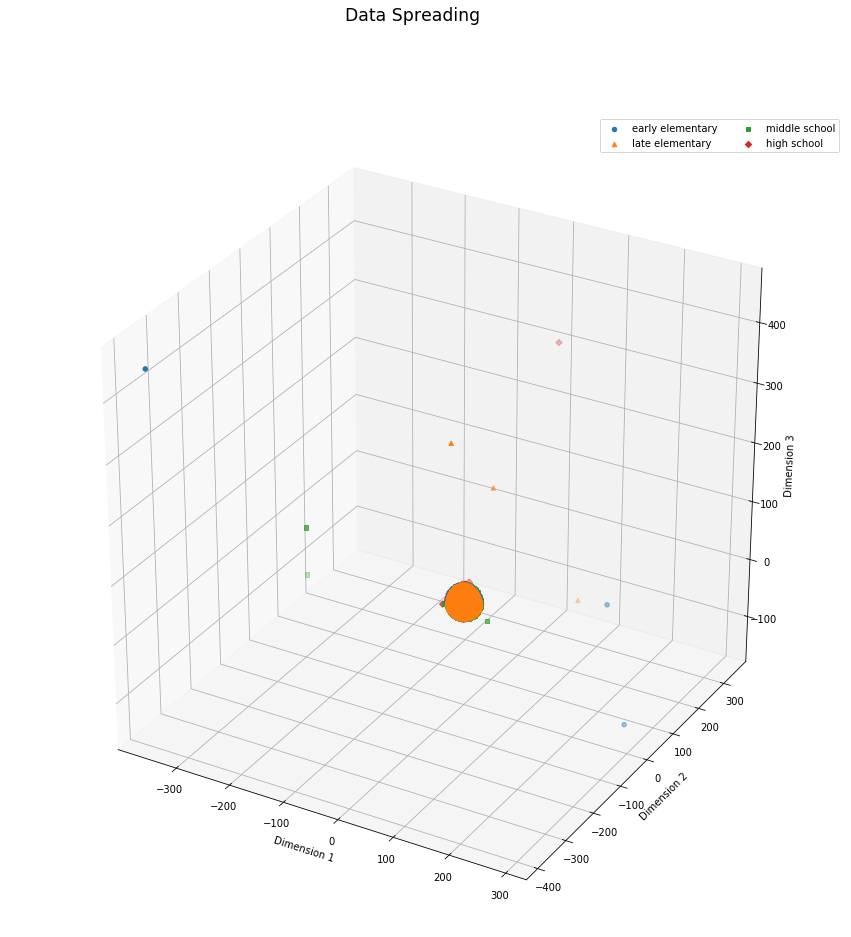

In [9]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectorized_values[vectorized_values['Lexiles']=='(0, 650]']['1'], vectorized_values[vectorized_values['Lexiles']=='(0, 650]']['2'], vectorized_values[vectorized_values['Lexiles']=='(0, 650]']['3'], marker="o", label="early elementary")
ax.scatter(vectorized_values[vectorized_values['Lexiles']=='(650, 1050]']['1'], vectorized_values[vectorized_values['Lexiles']=='(650, 1050]']['2'], vectorized_values[vectorized_values['Lexiles']=='(650, 1050]']['3'], marker="^", label="late elementary")
ax.scatter(vectorized_values[vectorized_values['Lexiles']=='(1050, 1200]']['1'], vectorized_values[vectorized_values['Lexiles']=='(1050, 1200]']['2'], vectorized_values[vectorized_values['Lexiles']=='(1050, 1200]']['3'], marker="s", label="middle school")
ax.scatter(vectorized_values[vectorized_values['Lexiles']=='(1200, 1400]']['1'], vectorized_values[vectorized_values['Lexiles']=='(1200, 1400]']['2'], vectorized_values[vectorized_values['Lexiles']=='(1200, 1400]']['3'], marker="D", label="high school")
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend(fancybox=True, ncol=2)
fig.suptitle('Data Spreading', size='xx-large');

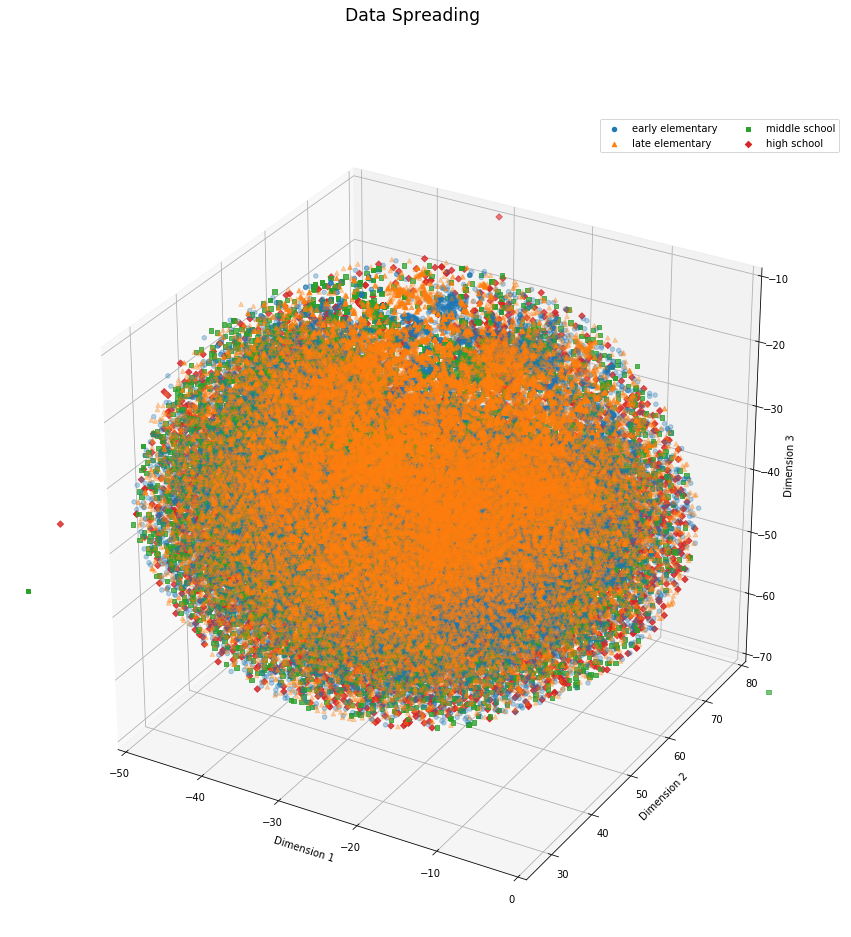

In [37]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectorized_values[vectorized_values['Lexiles']=='(0, 650]']['1'], vectorized_values[vectorized_values['Lexiles']=='(0, 650]']['2'], vectorized_values[vectorized_values['Lexiles']=='(0, 650]']['3'], marker="o", label="early elementary")
ax.scatter(vectorized_values[vectorized_values['Lexiles']=='(650, 1050]']['1'], vectorized_values[vectorized_values['Lexiles']=='(650, 1050]']['2'], vectorized_values[vectorized_values['Lexiles']=='(650, 1050]']['3'], marker="^", label="late elementary")
ax.scatter(vectorized_values[vectorized_values['Lexiles']=='(1050, 1200]']['1'], vectorized_values[vectorized_values['Lexiles']=='(1050, 1200]']['2'], vectorized_values[vectorized_values['Lexiles']=='(1050, 1200]']['3'], marker="s", label="middle school")
ax.scatter(vectorized_values[vectorized_values['Lexiles']=='(1200, 1400]']['1'], vectorized_values[vectorized_values['Lexiles']=='(1200, 1400]']['2'], vectorized_values[vectorized_values['Lexiles']=='(1200, 1400]']['3'], marker="D", label="high school")
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_xlim(left=-50, right=0)
ax.set_ylim(top=80, bottom=25)
ax.set_zlim(top=-10, bottom=-70)
ax.legend(fancybox=True, ncol=2)
fig.suptitle('Data Spreading', size='xx-large');

In [24]:
file = open('2d_vectors.pickle', 'rb')
transformed_data_2d = pickle.load(file)
file.close()

In [26]:
vectorized_values2 = pd.DataFrame()
vectorized_values2['Lexiles'] = para_data['Lexiles']
vectorized_values2['1'] = transformed_data_2d[:,0]
vectorized_values2['2'] = transformed_data_2d[:,1]

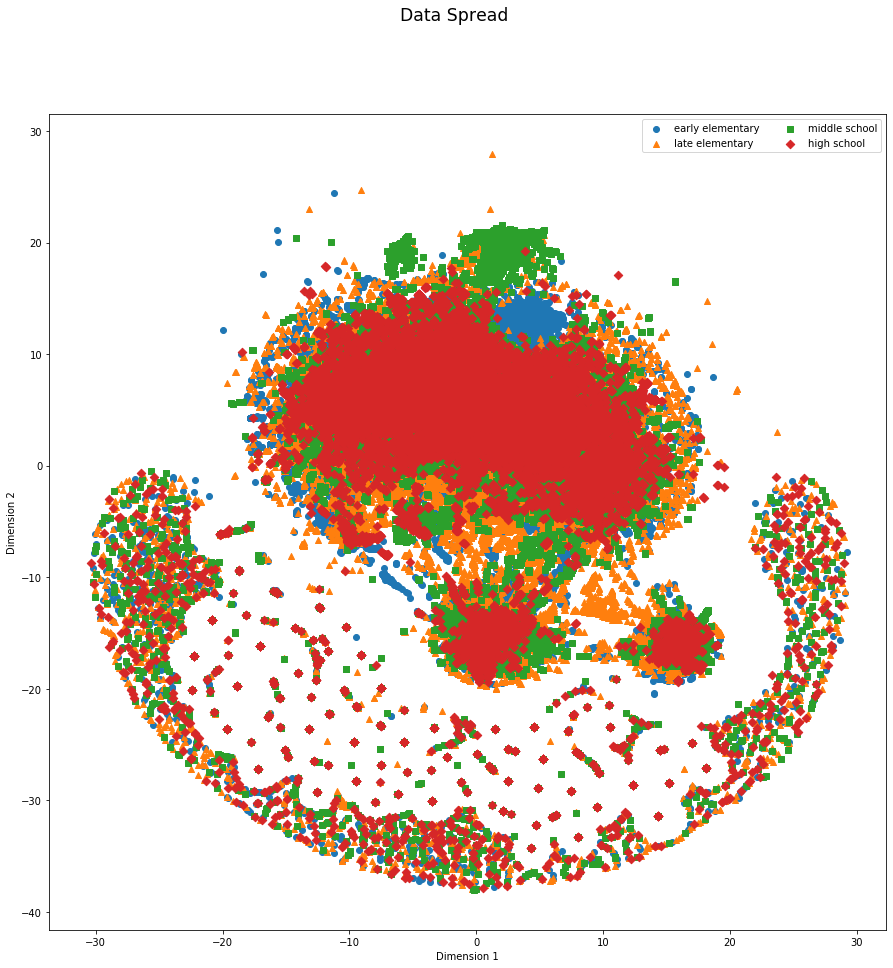

In [29]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.scatter(vectorized_values2[vectorized_values2['Lexiles']=='(0, 650]']['1'], vectorized_values2[vectorized_values2['Lexiles']=='(0, 650]']['2'], marker="o", label="early elementary")
ax.scatter(vectorized_values2[vectorized_values2['Lexiles']=='(650, 1050]']['1'], vectorized_values2[vectorized_values2['Lexiles']=='(650, 1050]']['2'], marker="^", label="late elementary")
ax.scatter(vectorized_values2[vectorized_values2['Lexiles']=='(1050, 1200]']['1'], vectorized_values2[vectorized_values2['Lexiles']=='(1050, 1200]']['2'], marker="s", label="middle school")
ax.scatter(vectorized_values2[vectorized_values2['Lexiles']=='(1200, 1400]']['1'], vectorized_values2[vectorized_values2['Lexiles']=='(1200, 1400]']['2'], marker="D", label="high school")
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(fancybox=True, ncol=2)
fig.suptitle('Data Spread', size='xx-large');

In [52]:
histo_data = pd.DataFrame(one_hot_results)
histo_data['Lexiles'] = para_data['Lexiles']

([array([9.994e+03, 5.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
  array([9.994e+03, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
  array([9.998e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
  array([9.998e+03, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
  array([9.999e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
  array([9.999e+03, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
  array([9.996e+03, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
  array([9.998e+03, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
         0.000e

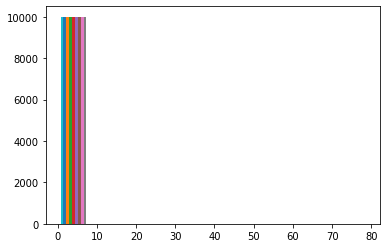

In [54]:
plt.hist(histo_data[histo_data['Lexiles']=='(0, 650]'].drop('Lexiles', axis=1));

In [66]:
value_counts_data = []
for i in histo_data[histo_data['Lexiles']=='(0, 650]'].drop('Lexiles', axis=1).columns:
    value_counts_data.append(histo_data[i].value_counts())

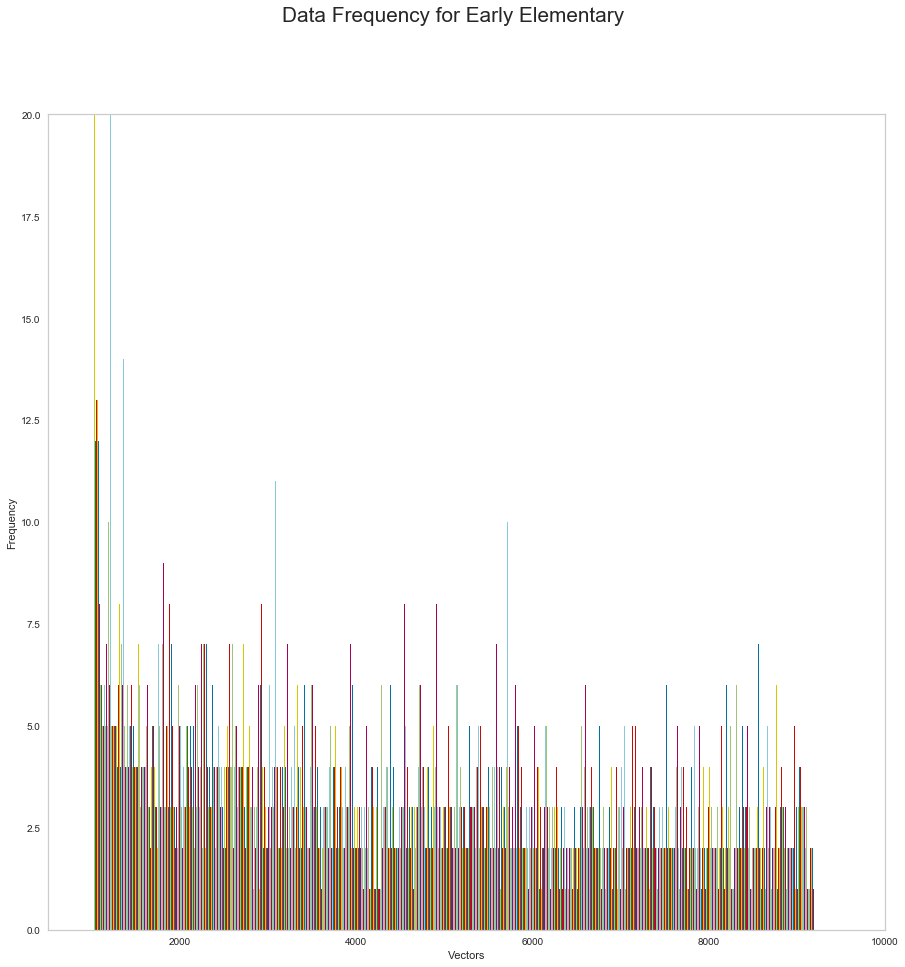

In [87]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.hist(value_counts_data)
ax.set_xlim(left=500, right=10000)
ax.set_ylim(bottom=0, top=20)
ax.set_xlabel('Vectors')
ax.set_ylabel('Frequency')
ax.grid(b=False)
fig.suptitle('Data Frequency for Early Elementary', size='xx-large');

In [72]:
value_counts_data = []
for i in histo_data[histo_data['Lexiles']=='(650, 1050]'].drop('Lexiles', axis=1).columns:
    value_counts_data.append(histo_data[i].value_counts())

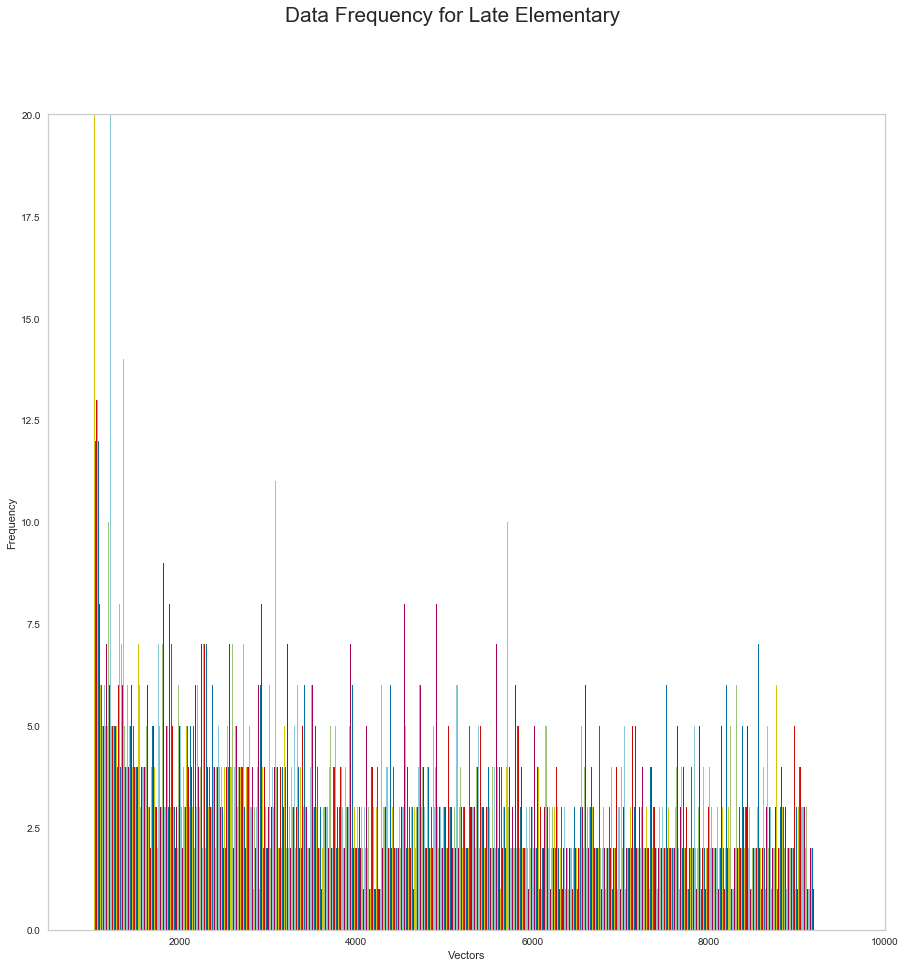

In [77]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.hist(value_counts_data)
ax.set_xlim(left=500, right=10000)
ax.set_ylim(bottom=0, top=20)
ax.set_xlabel('Vectors')
ax.set_ylabel('Frequency')
ax.grid(b=False)
fig.suptitle('Data Frequency for Late Elementary', size='xx-large');

In [80]:
value_counts_data = []
for i in histo_data[histo_data['Lexiles']=='(1050, 1200]'].drop('Lexiles', axis=1).columns:
    value_counts_data.append(histo_data[i].value_counts())

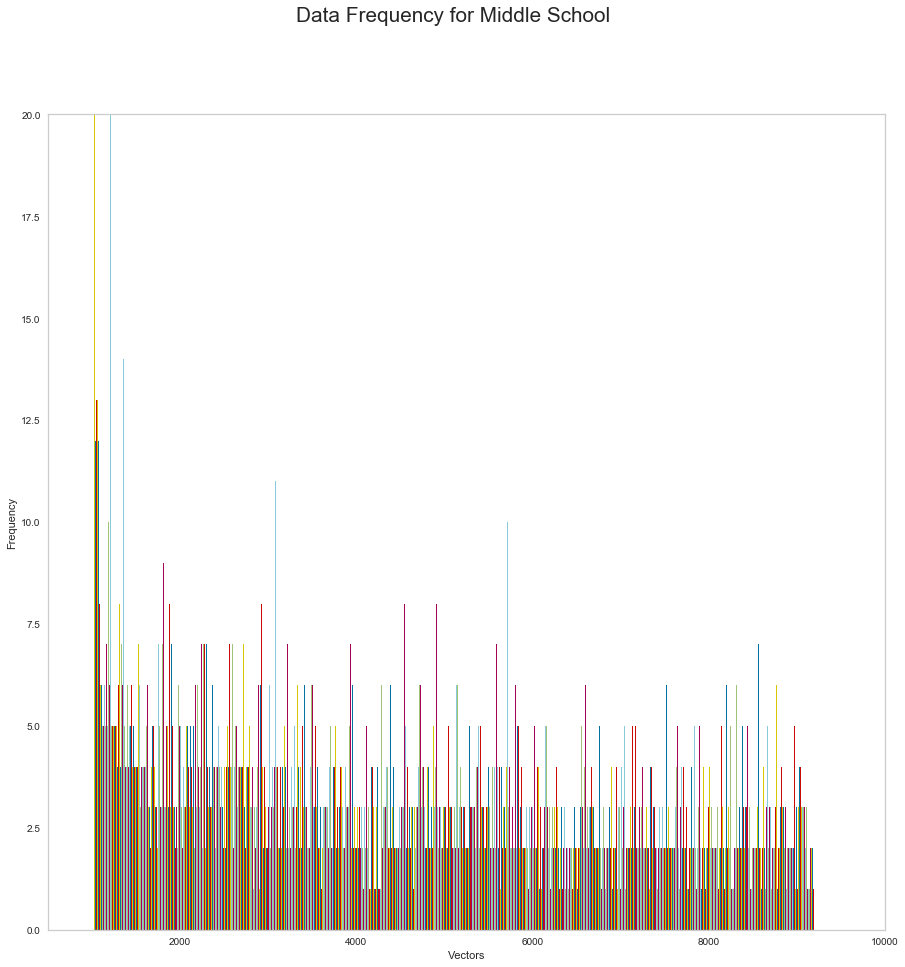

In [82]:
fig = plt.figure(figsize=(15, 15), facecolor=None)
ax = fig.add_subplot(111)
ax.hist(value_counts_data)
ax.set_xlim(left=500, right=10000)
ax.set_ylim(bottom=0, top=20)
ax.set_xlabel('Vectors')
ax.set_ylabel('Frequency')
ax.grid(b=False)
fig.suptitle('Data Frequency for Middle School', size='xx-large');

In [85]:
value_counts_data = []
for i in histo_data[histo_data['Lexiles']=='(1200, 1400]'].drop('Lexiles', axis=1).columns:
    value_counts_data.append(histo_data[i].value_counts())

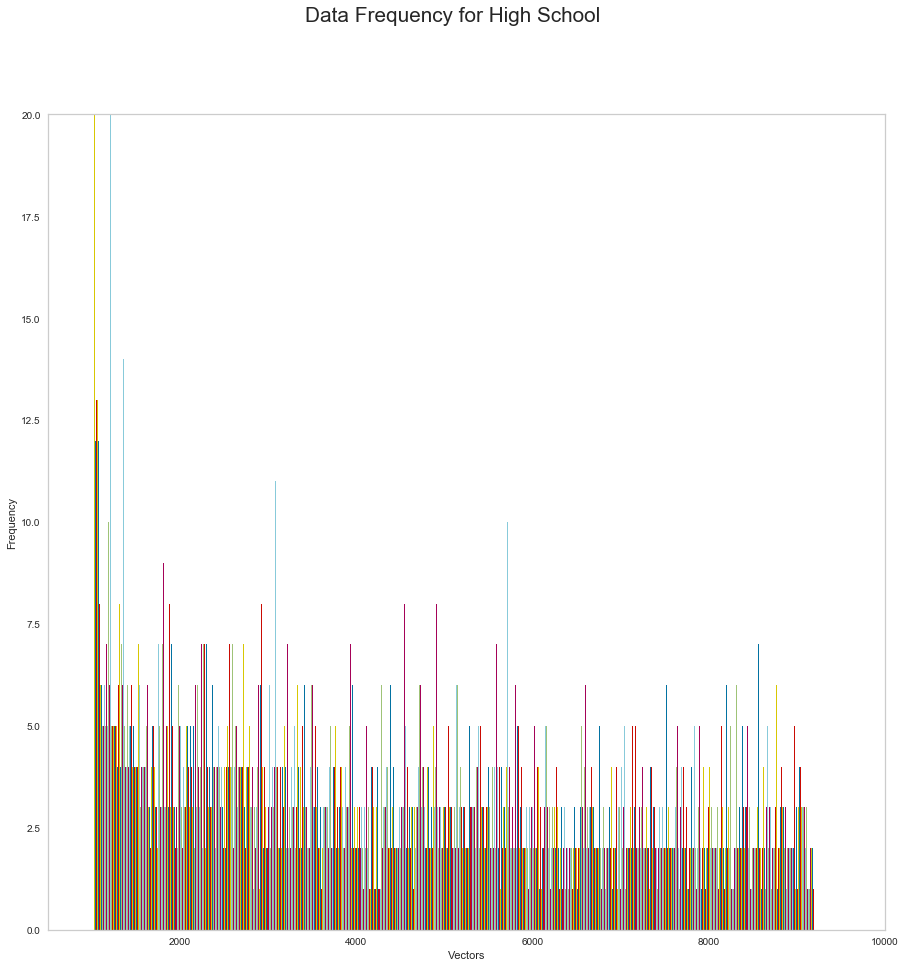

In [86]:
fig = plt.figure(figsize=(15, 15), facecolor=None)
ax = fig.add_subplot(111)
ax.hist(value_counts_data)
ax.set_xlim(left=500, right=10000)
ax.set_ylim(bottom=0, top=20)
ax.set_xlabel('Vectors')
ax.set_ylabel('Frequency')
ax.grid(b=False)
fig.suptitle('Data Frequency for High School', size='xx-large');

## Lexile Level Interpretation

In [30]:
grade_df = pd.read_csv('Lexile levels by grade.csv')
grade_df

,Unnamed: 0,50th,90th
0,K,BR160L,150L
1,1,165L,570L
2,2,425L,795L
3,3,645L,985L
4,4,850L,1160L
5,5,950L,1260L
6,6,1030L,1340L
7,7,1095L,1410L
8,8,1155L,1470L
9,9,1205L,1520L


<a href='#Background'>Back to top</a>

# Future Work <a id='Future'></a>

predictive text

sonority sequencing from nltk

<a href='#Background'>Back to top</a>

# References <a id='References'></a>

- http://allselenium.info/working-with-checkboxes-using-python-selenium-webdriver/ 
- https://github.com/BryanBumgardner/gutenburg_nlp - elizabethan stop words
- http://brandonrose.org/clustering - structure of stemming and tokenizing for visualization
- https://machinelearningmastery.com/save-load-keras-deep-learning-models/ various save methods for keras models
- https://medium.com/@ODSC/transforming-skewed-data-for-machine-learning-90e6cc364b0 - for neural network adjustment for skew
- Tsai, A.C., Liou, M., Simak, M., Cheng, P.E., On hyperbolictransformations to normality. Computational Statistics and Data Analysis (2017),http://dx.doi.org/10.1016/j.csda.2017.06.001
- Klambauer, G., Unterthiner, T., Mayr, A., & Hochreiter, S. (2017). Self-Normalizing Neural Networks. In Advances in Neural Information Processing Systems (NIPS).
- https://medium.com/@mikaelagurney/add-dynamic-components-to-your-html-templates-using-form-s-flask-and-jinja-59b4169ec3e1 for dynamic page loading without javascript using jinja

<a href='#Background'>Back to top</a>